In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys

from matplotlib import pyplot as plt
from pandas.io.json import json_normalize

import logging
logger = logging.getLogger(__name__)

# These lines allow me to see logging.info messages in my jupyter cell output
logger.addHandler(logging.StreamHandler(stream=sys.stdout)) 
logger.setLevel(logging.DEBUG)

# Grab subject & trial info

In [7]:
class subject_data():

    def __init__(self, subject_data_folder):
        
        self.sub_id = os.path.split(subject_data_folder)[-1]
        self.data_parent_folder = os.path.join(*os.path.split(subject_data_folder)[:-1])
        self.data_folder = subject_data_folder
        
        self.experiment_settings = None # Making the attribute known
        self.read_experiment_settings_from_file() # self.experiment_settings is now set
        #self.experiment_settings['figure_out_folder'] = self.get_figure_out_folder('figs')
        
        self.results = None
        self.read_trial_results_from_file()
 
    def get_trial_from_index(self,trial_index):
        
        return trial_data(self.results.iloc[trial_index],self.experiment_settings,self.data_folder)
    
    def read_experiment_settings_from_file(self):

        settings_path = os.path.join(self.data_folder, 'S001', 'session_info', 'settings.json')

        with open(settings_path) as json_data:
            self.experiment_settings = json.load(json_data)
            
    def read_trial_results_from_file(self):

        trial_data_path = os.path.join(self.data_folder, 'S001')
        self.results = pd.read_csv( os.path.join( trial_data_path, 'trial_results.csv' ))
    
class trial_data():
    
    def __init__(self,trial_results_row_in, experiment_settings, subject_data_folder):
        
        self.data_parent_folder = os.path.join(*os.path.split(subject_data_folder)[:-1])
        self.data_folder = subject_data_folder
        
        self.results = trial_results_row_in
        self.experiment_settings = experiment_settings

        # Get raw data
        self.road_vertices = pd.read_csv(os.path.join(self.data_parent_folder, *trial_results_row_in['road_vertices_location_0'].split('/')[1:]))
        self.road_data = pd.read_csv(os.path.join(self.data_parent_folder, *trial_results_row_in['roadTransformMat_location_0'].split('/')[1:]))
        self.car_data = pd.read_csv(os.path.join(self.data_parent_folder,*trial_results_row_in['simplecar_carTransformMatrix_location_0'].split('/')[1:]))
    
    def calculate_BRT(self, warning_time):
        brake_position = self.car_data['brake_position']
        time = self.car_data['time']               
        BRT = "NaN"
        count = -1
        
        if warning_time == "NaN":
            BRT = "NaN"
        else:
            for brake_pos in brake_position:
                count = count + 1
                if brake_pos > 0:
                    time_break_applied = time[count]
                    BRT = warning_time - time_break_applied
                    break
    
        return BRT
    
    def get_wheel_angle_data(self):
        # Grabbing the time-stamp and corresponding wheel angle for the trial
        wheel_angles_from_trial = self.car_data[['time','wheelAngle']]
        wheel_angle_array = np.array(wheel_angles_from_trial)
        zeroed_time = []
        
        for t_idx in range(0,len(wheel_angle_array)):
            dif = wheel_angle_array[t_idx, 0] - wheel_angle_array[0,0]
            zeroed_time.append(dif)
        
        wheel_angle_array[:,0] = zeroed_time

        return wheel_angle_array
    
    def filter_wheel_data(self, wheel_angles):
        filtered_time = []
        filtered_wheel_angles = []

        for first_term_idx in range(0,len(wheel_angles)-1):
            ang_dif = wheel_angles[first_term_idx+1,1]-wheel_angles[first_term_idx,1]
            time_dif = wheel_angles[first_term_idx+1,0]-wheel_angles[first_term_idx,0]
            if ang_dif/time_dif != 0:
                filtered_time.append(wheel_angles[first_term_idx+1,0])
                filtered_wheel_angles.append(wheel_angles[first_term_idx+1,1])
        
        filtered_wheel_data = list(zip(filtered_time,filtered_wheel_angles))
        
        return filtered_wheel_data
    
    def calculate_ttc_brake(self):
        car_speed = self.car_data['pos_x']
        car_x = self.car_data['pos_x']
        car_z = self.car_data['pos_z']
        obs_x = self.car_data['obstacle_pos_x']
        obs_z = self.car_data['obstacle_pos_z']

        car_distMoved = np.sqrt((car_x-obs_x)**2 + (car_z-obs_z)**2 ) 
        car_speed = car_distMoved[1:] / time_dif[:-1]

        return wheel_angle_array
    
    def calculate_car_speed(self):
        # Grab data and zero the time
        car_pos_from_trial = self.car_data[['time','pos_x','pos_z']]
        car_position_array = np.array(car_pos_from_trial)
        zeroed_time = []
        car_speed = []
        
        time_dif = self.car_data['time'].diff()
        
        for t_idx in range(0,len(car_position_array)):
            time_dif = car_position_array[t_idx, 0] - car_position_array[0,0]
            zeroed_time.append(round(time_dif,2))
            
        for t_idx in range(0,len(car_position_array)-1):
            time = zeroed_time[t_idx+1] - zeroed_time[t_idx]
            dist_between_frames = (((car_position_array[t_idx+1,1]-car_position_array[t_idx,1])**2)+((car_position_array[t_idx+1,2]-car_position_array[t_idx,2])**2))**(1/2)
            speed = dist_between_frames/time
            car_speed.append(round(speed,4))
        
        car_speed_data = list(zip(zeroed_time[1:],car_speed))

        fig, ax = plt.subplots()
        ax.scatter(zeroed_time[1:], car_speed)
        plt.xlabel('Time')
        plt.ylabel('Car Speed')
        plt.title('Velocity Over Time')
        plt.show()
        
        
        return car_speed_data

    def max_deceleration(self, car_speed):
        
        return max_acc
    '''
    def max_wheel_velocity(self, filtered_wheel_data):
        wheel_vel = []        
        
        for first_term_idx in range(0,len(filtered_wheel_data)-1):
            ang_dif = filtered_wheel_data[first_term_idx+1][1]-filtered_wheel_data[first_term_idx][1]
            time_dif = filtered_wheel_data[first_term_idx+1][0]-filtered_wheel_data[first_term_idx][0]
            wheel_vel.append(ang_dif/time_dif)

        filtered_wheel_data_array = np.array(filtered_wheel_data)
        
        # plot
        fig, ax = plt.subplots()
        ax.scatter(filtered_wheel_data_array[1:,0], wheel_vel)
        plt.xlabel('Time')
        plt.ylabel('Velocity of Wheel Angle Change')
        plt.title('Velocity of Wheel Angle Change Over Time')
        plt.show()
        
        # Print out max change over time
        max_angle_idx = np.argmax(abs(np.array(wheel_vel)))
        
        if wheel_vel[max_angle_idx]<0:
            max_angle = np.amin(wheel_vel)
        else:
            max_angle = np.amax(wheel_vel)
        
        print("Max wheel angle change velocity = "+ str(round(max_angle,2)) +" degrees/second at "+ str(round(filtered_wheel_data[max_angle_idx+1][0],2))+ " seconds after the trial began.")
        
        time_of_max_wheel_acc = filtered_wheel_data[max_angle_idx+1][0]
        
        return time_of_max_wheel_acc
    '''

# Analysis

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


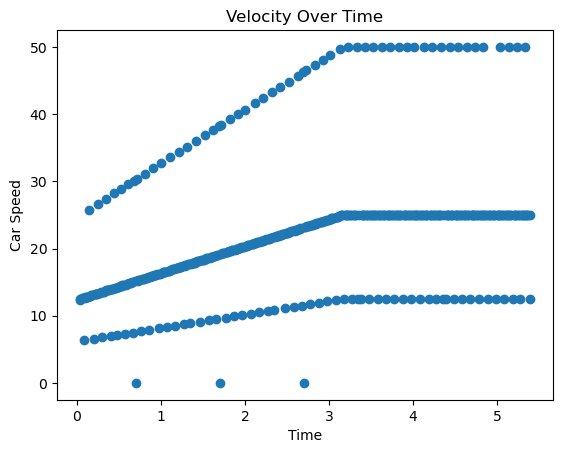

[(0.03, 12.3999), (0.04, 12.4799), (0.04, inf), (0.05, 12.5609), (0.06, 12.5999), (0.08, 6.32), (0.09, 12.68), (0.1, 12.72), (0.11, 12.76), (0.12, 12.8001), (0.13, 12.8391), (0.14, 25.8002), (0.15, 12.9602), (0.16, 13.0002), (0.17, 13.0402), (0.18, 13.0792), (0.2, 6.5601), (0.21, 13.1603), (0.22, 13.1993), (0.23, 13.2404), (0.24, 13.2804), (0.25, 26.6799), (0.26, 13.3995), (0.27, 13.4405), (0.28, 13.4796), (0.3, 6.7603), (0.31, 13.5596), (0.32, 13.5997), (0.33, 13.6397), (0.34, 27.4005), (0.35, 13.7598), (0.36, 13.7998), (0.37, 13.8399), (0.38, 13.8809), (0.4, 6.96), (0.41, 13.96), (0.42, 14.0), (0.43, 14.0401), (0.44, 28.1993), (0.45, 14.1602), (0.46, 14.2002), (0.48, 7.1201), (0.49, 14.2793), (0.5, 14.3204), (0.51, 14.3604), (0.52, 28.84), (0.53, 14.4796), (0.54, 14.5196), (0.55, 14.5606), (0.57, 7.2998), (0.58, 14.6397), (0.59, 14.6798), (0.6, 14.7198), (0.61, 29.5597), (0.62, 14.8409), (0.63, 14.8799), (0.64, 14.92), (0.65, 14.96), (0.67, 7.5), (0.68, 30.1202), (0.69, 15.1191), (0.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


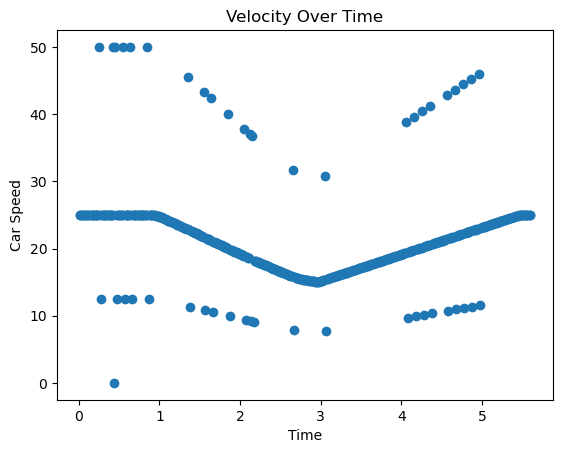

[(0.01, 25.0013), (0.02, 25.0), (0.03, 24.9996), (0.04, 24.9993), (0.06, 25.0007), (0.07, 24.9973), (0.08, 25.0028), (0.09, 24.9984), (0.1, 24.9999), (0.12, 24.9998), (0.12, nan), (0.13, 25.0016), (0.15, 25.0005), (0.16, 25.0003), (0.17, 24.9979), (0.18, 25.0025), (0.19, 24.9961), (0.2, 25.0034), (0.21, 24.9992), (0.22, 24.9996), (0.23, 24.9963), (0.24, 25.0006), (0.25, 50.0018), (0.27, 12.5011), (0.28, 24.9978), (0.29, 25.0013), (0.3, 24.9979), (0.31, 25.0023), (0.32, 24.9999), (0.33, 25.0005), (0.34, 24.9982), (0.35, 24.9997), (0.37, 25.0011), (0.38, 24.9977), (0.39, 25.0022), (0.4, 24.9982), (0.41, 25.0017), (0.42, 24.9997), (0.43, 49.9979), (0.44, 0.0), (0.45, 49.9995), (0.47, 12.4996), (0.48, 25.0011), (0.49, 25.0002), (0.5, 25.0031), (0.51, 24.9967), (0.52, 24.9997), (0.53, 25.0017), (0.54, 25.0), (0.55, 50.0008), (0.57, 12.4995), (0.58, 25.0011), (0.59, 24.9987), (0.6, 25.0018), (0.61, 24.9986), (0.62, 24.9982), (0.63, 25.003), (0.64, 49.9968), (0.66, 12.5009), (0.67, 24.9998), 

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


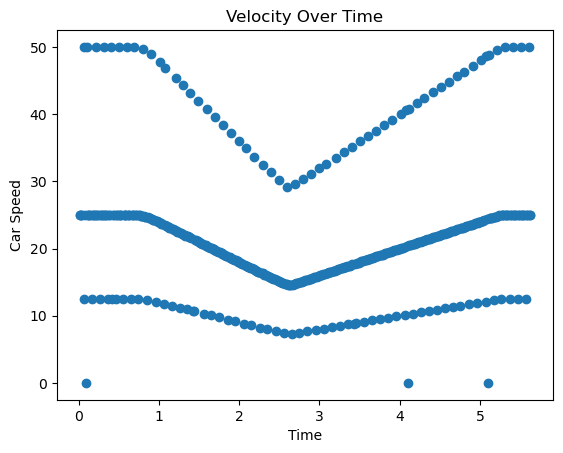

[(0.01, 25.0022), (0.02, 24.9974), (0.03, 25.0022), (0.04, 25.003), (0.06, 12.4979), (0.07, 49.9987), (0.08, 25.0013), (0.09, 0.0), (0.1, 50.0035), (0.11, 24.9957), (0.12, 25.0013), (0.13, 25.0005), (0.14, 25.0022), (0.16, 12.4983), (0.17, 25.0013), (0.18, 24.9974), (0.19, 25.0022), (0.2, 24.9982), (0.21, 50.002), (0.22, 24.9998), (0.23, 24.999), (0.24, 25.0007), (0.26, 12.5003), (0.27, 25.0015), (0.28, 24.9975), (0.29, 25.0031), (0.3, 24.9983), (0.31, 50.0), (0.32, 25.0016), (0.33, 24.996), (0.34, 25.0033), (0.35, 24.9993), (0.37, 12.5001), (0.38, 25.0026), (0.39, 24.9978), (0.4, 49.9966), (0.42, 12.5014), (0.43, 25.0005), (0.43, inf), (0.44, 24.9998), (0.46, 12.5011), (0.47, 25.0), (0.48, 24.9969), (0.49, 25.0002), (0.5, 50.0047), (0.51, 24.9981), (0.52, 25.0006), (0.53, 24.9991), (0.55, 12.5012), (0.56, 24.9985), (0.57, 24.997), (0.58, 24.9995), (0.59, 25.0029), (0.6, 50.0012), (0.61, 25.0), (0.62, 24.9969), (0.63, 25.0041), (0.65, 12.4981), (0.66, 25.0035), (0.67, 25.0004), (0.68, 

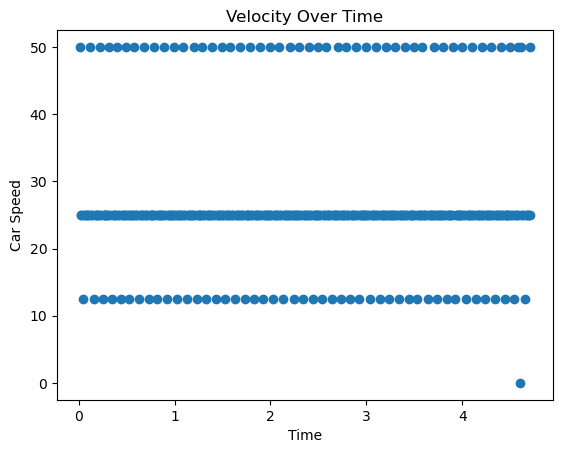

[(0.01, 49.9993), (0.02, 24.9994), (0.03, 24.9992), (0.05, 12.4995), (0.06, 25.0018), (0.07, 25.0008), (0.08, 24.9997), (0.09, 25.0015), (0.1, 24.9996), (0.11, 24.9976), (0.12, 50.0007), (0.13, 24.9993), (0.14, 25.0011), (0.16, 12.4996), (0.17, 25.0001), (0.18, 25.0019), (0.19, 24.999), (0.2, 25.0009), (0.21, 24.9989), (0.22, 50.0015), (0.23, 24.9997), (0.25, 12.4989), (0.26, 25.0025), (0.27, 25.0005), (0.28, 24.9986), (0.29, 24.9995), (0.3, 25.0013), (0.31, 24.9994), (0.32, 49.9987), (0.33, 25.0002), (0.35, 12.501), (0.36, 24.9992), (0.37, 25.001), (0.38, 24.9982), (0.39, 25.0), (0.4, 49.998), (0.41, 25.0009), (0.42, 24.9989), (0.44, 12.5004), (0.45, 25.0017), (0.46, 25.0007), (0.47, 24.9969), (0.48, 25.0026), (0.49, 50.0003), (0.5, 24.9997), (0.51, 24.9977), (0.53, 12.4998), (0.54, 25.0015), (0.55, 25.0024), (0.56, 24.9967), (0.57, 25.0014), (0.58, 50.0018), (0.59, 24.9985), (0.6, 25.0013), (0.61, 24.9976), (0.63, 12.5002), (0.64, 25.0013), (0.65, 25.0003), (0.66, 25.0003), (0.67, 24

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


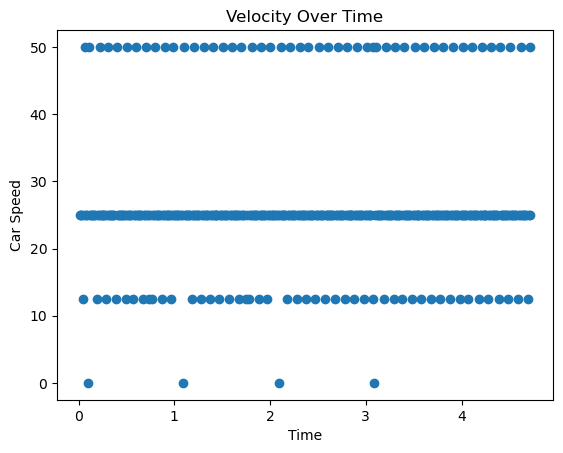

[(0.01, 24.9984), (0.02, 24.9955), (0.03, 25.0065), (0.05, 12.499), (0.06, 24.9952), (0.07, 50.0041), (0.08, 25.0006), (0.09, 24.9922), (0.1, 0.0), (0.11, 50.0037), (0.12, 25.006), (0.13, 24.9976), (0.14, 25.0004), (0.15, 25.0059), (0.16, 24.9976), (0.17, 24.9948), (0.19, 12.5029), (0.2, 24.9976), (0.21, 25.0031), (0.22, 50.0007), (0.23, 24.9976), (0.24, 24.9976), (0.25, 25.0004), (0.26, 24.9949), (0.27, 25.0004), (0.29, 12.503), (0.3, 25.006), (0.31, 49.9954), (0.32, 24.9977), (0.33, 25.0033), (0.34, 24.9977), (0.35, 24.9977), (0.36, 25.0033), (0.37, 24.9977), (0.39, 12.4989), (0.4, 49.9982), (0.41, 25.006), (0.42, 24.9949), (0.43, 25.0004), (0.44, 25.0032), (0.45, 25.0032), (0.46, 24.9976), (0.47, 24.9976), (0.49, 12.4988), (0.5, 25.0004), (0.51, 50.0007), (0.52, 24.9948), (0.53, 25.0031), (0.54, 25.0031), (0.55, 24.9976), (0.57, 12.5016), (0.58, 25.0059), (0.59, 24.9976), (0.6, 49.9979), (0.61, 24.9976), (0.62, 25.0059), (0.63, 24.992), (0.64, 25.0114), (0.65, 24.9976), (0.67, 12.50

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


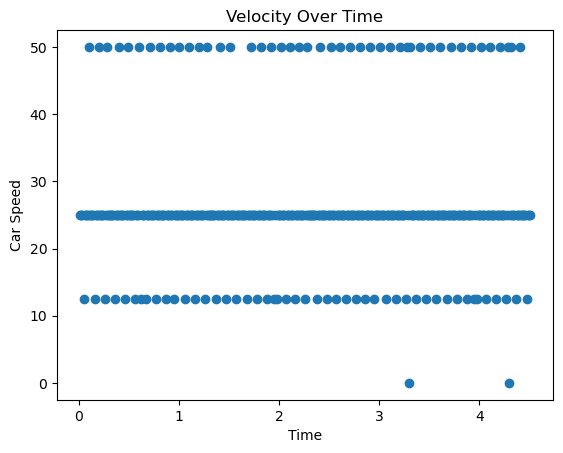

[(0.01, 25.0001), (0.02, 25.0001), (0.03, 25.0001), (0.05, 12.5), (0.06, 25.0001), (0.07, 25.0), (0.08, 25.0), (0.09, 25.0), (0.1, 50.0), (0.11, 25.0), (0.12, 25.0), (0.13, 25.0), (0.14, 25.0), (0.16, 12.5), (0.17, 25.0), (0.18, 25.0), (0.19, 25.0), (0.2, 50.0), (0.21, 25.01), (0.22, 24.99), (0.23, 25.0), (0.24, 25.0), (0.26, 12.5), (0.27, 25.0), (0.28, 50.0001), (0.29, 25.0001), (0.3, 25.0001), (0.31, 25.0001), (0.32, 25.0001), (0.33, 25.0001), (0.34, 25.0001), (0.36, 12.5001), (0.37, 25.0002), (0.38, 25.0002), (0.39, 25.0002), (0.4, 50.0005), (0.41, 25.0003), (0.42, 25.0003), (0.43, 25.0003), (0.44, 25.0003), (0.46, 12.5002), (0.47, 25.0004), (0.48, 25.0004), (0.49, 50.0009), (0.5, 25.0104), (0.51, 24.9905), (0.52, 25.0005), (0.53, 25.0005), (0.54, 25.0004), (0.56, 12.5003), (0.57, 25.0004), (0.58, 25.0004), (0.59, 25.0004), (0.6, 50.0007), (0.62, 12.5001), (0.62, inf), (0.63, 25.0002), (0.64, 25.0002), (0.65, 25.0001), (0.67, 12.5), (0.68, 25.0), (0.69, 25.0), (0.7, 25.0), (0.71, 50

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


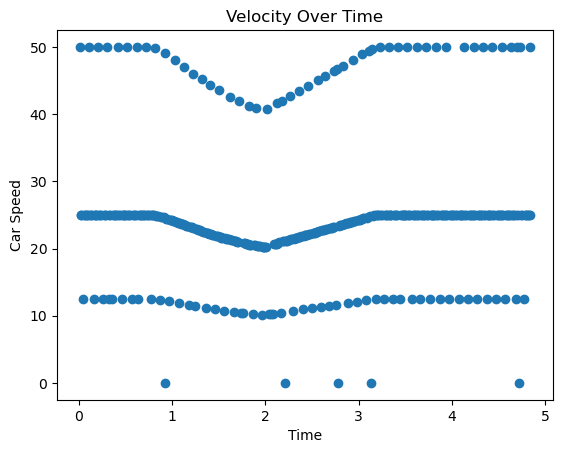

[(0.01, 50.0006), (0.02, 25.0016), (0.03, 25.0016), (0.05, 12.5008), (0.06, 24.9919), (0.07, 25.0041), (0.08, 25.0016), (0.09, 25.0041), (0.1, 24.9919), (0.11, 50.0006), (0.12, 24.9991), (0.13, 25.0087), (0.14, 24.9991), (0.16, 12.4983), (0.17, 24.9966), (0.18, 25.0062), (0.19, 24.9966), (0.2, 25.0037), (0.21, 49.9978), (0.22, 25.0012), (0.23, 25.0012), (0.24, 25.0012), (0.26, 12.4945), (0.27, 25.0084), (0.28, 24.9987), (0.29, 24.9962), (0.3, 49.9997), (0.32, 12.5017), (0.32, inf), (0.33, 25.001), (0.34, 24.996), (0.36, 12.4992), (0.37, 25.0032), (0.38, 24.996), (0.39, 25.0008), (0.4, 25.0008), (0.41, 24.9958), (0.42, 50.0014), (0.43, 25.0031), (0.44, 25.0006), (0.46, 12.4991), (0.47, 25.0079), (0.48, 24.9958), (0.49, 24.9958), (0.5, 25.003), (0.51, 25.003), (0.52, 50.0036), (0.53, 24.9909), (0.54, 24.9981), (0.55, 25.0006), (0.57, 12.5003), (0.58, 24.9981), (0.59, 25.003), (0.6, 25.0006), (0.61, 25.003), (0.62, 50.0012), (0.64, 12.4979), (0.65, 24.9982), (0.66, 25.0031), (0.67, 24.993

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


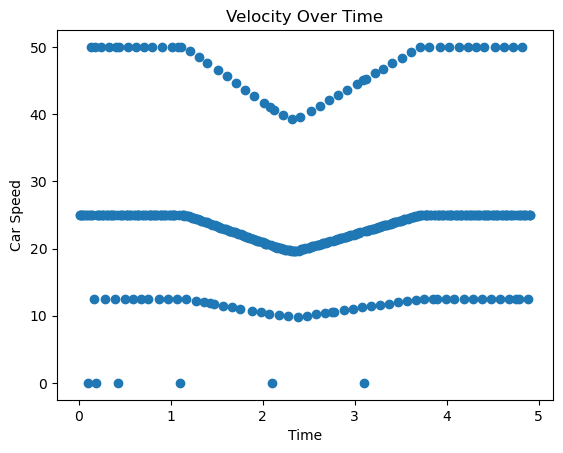

[(0.01, 24.9985), (0.02, 25.0028), (0.03, 24.9938), (0.04, 25.0072), (0.05, 24.9938), (0.06, 24.9982), (0.08, 25.0003), (0.09, 24.9982), (0.1, 0.0), (0.11, 25.0025), (0.12, 24.9982), (0.13, 50.005), (0.14, 24.9978), (0.15, 25.0025), (0.17, 12.4967), (0.18, 50.0003), (0.19, 0.0), (0.2, 24.9978), (0.21, 25.0111), (0.22, 24.9978), (0.23, 24.9978), (0.24, 50.0043), (0.25, 24.9931), (0.26, 25.0021), (0.27, 24.9975), (0.29, 12.5009), (0.3, 24.9975), (0.31, 25.0018), (0.32, 24.9971), (0.33, 50.0033), (0.34, 25.0015), (0.35, 25.0015), (0.36, 24.9968), (0.37, 24.9968), (0.38, 25.0012), (0.4, 12.5006), (0.41, 50.0021), (0.42, 25.0009), (0.43, 0.0), (0.44, 50.0062), (0.45, 24.9963), (0.46, 24.9963), (0.47, 25.0007), (0.48, 25.0051), (0.5, 12.498), (0.51, 24.9961), (0.52, 25.0004), (0.53, 25.0048), (0.54, 50.0007), (0.55, 24.9958), (0.56, 25.0046), (0.57, 24.9913), (0.59, 12.5045), (0.6, 24.9957), (0.61, 25.0), (0.62, 49.9999), (0.63, 24.9999), (0.64, 24.9999), (0.65, 24.9999), (0.66, 25.0043), (0

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


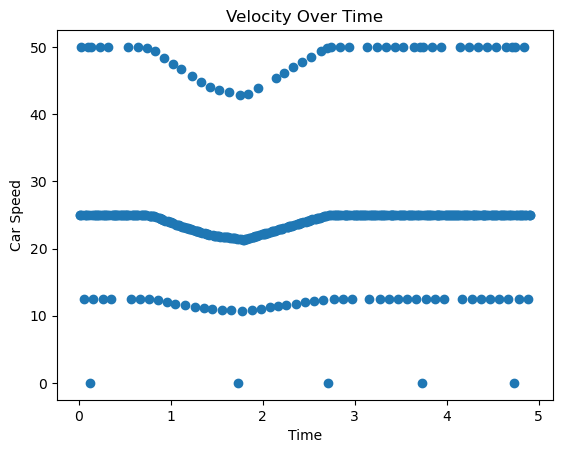

[(0.01, 24.9968), (0.02, 25.0012), (0.03, 49.9978), (0.04, 25.0056), (0.06, 12.5005), (0.07, 24.9919), (0.08, 25.0053), (0.09, 24.9963), (0.1, 49.997), (0.11, 25.0007), (0.12, 0.01), (0.13, 50.0011), (0.14, 24.9961), (0.16, 12.5024), (0.17, 24.9958), (0.18, 25.0048), (0.19, 25.0002), (0.2, 25.0002), (0.21, 24.9957), (0.22, 25.0046), (0.23, 50.0001), (0.24, 24.9955), (0.26, 12.5), (0.27, 24.9999), (0.28, 25.0089), (0.29, 24.9909), (0.3, 25.0043), (0.31, 25.0043), (0.32, 49.9995), (0.33, 24.9952), (0.35, 12.5021), (0.36, 24.9952), (0.37, 25.004), (0.38, 24.9996), (0.39, 25.0085), (0.4, 24.9951), (0.41, 24.9995), (0.42, 24.9995), (0.43, 24.995), (0.45, 25.0039), (0.46, 24.9994), (0.47, 24.9994), (0.48, 24.9904), (0.49, 25.0083), (0.5, 24.9993), (0.51, 24.9904), (0.52, 25.0038), (0.53, 24.9993), (0.54, 49.9986), (0.55, 25.0037), (0.57, 12.4996), (0.58, 24.9992), (0.59, 24.9992), (0.6, 25.0037), (0.61, 24.9948), (0.62, 25.0082), (0.63, 24.9903), (0.64, 50.0074), (0.65, 24.9992), (0.67, 12.4

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


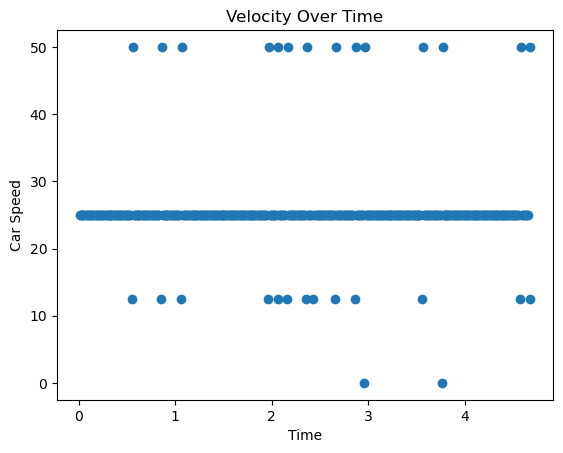

[(0.01, 24.9963), (0.02, 24.9963), (0.03, 25.005), (0.04, 25.0001), (0.05, 25.0001), (0.06, 24.9952), (0.08, 25.0015), (0.09, 24.9942), (0.1, 24.999), (0.11, 25.0029), (0.12, 25.0029), (0.13, 24.998), (0.14, 25.0019), (0.15, 24.9932), (0.16, 25.0106), (0.18, 24.997), (0.19, 25.0058), (0.2, 25.0009), (0.21, 24.996), (0.22, 24.996), (0.23, 25.0048), (0.24, 24.9999), (0.25, 24.9999), (0.26, 24.9999), (0.28, 25.0038), (0.29, 24.999), (0.3, 24.9902), (0.31, 25.0126), (0.32, 24.9902), (0.33, 24.999), (0.34, 25.0038), (0.35, 24.999), (0.36, 25.0038), (0.38, 24.9995), (0.39, 24.9863), (0.4, 25.0087), (0.41, 24.9999), (0.42, 25.0048), (0.43, 24.9922), (0.44, 25.0009), (0.45, 25.0058), (0.47, 25.0), (0.48, 24.9893), (0.49, 25.0116), (0.5, 24.999), (0.51, 24.9952), (0.52, 25.0001), (0.53, 25.0001), (0.55, 12.5006), (0.56, 49.9985), (0.57, 24.9984), (0.58, 25.0071), (0.59, 24.9946), (0.6, 24.9995), (0.61, 25.0045), (0.62, 24.9958), (0.63, 25.0056), (0.64, 24.9969), (0.66, 25.0018), (0.67, 25.003),

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


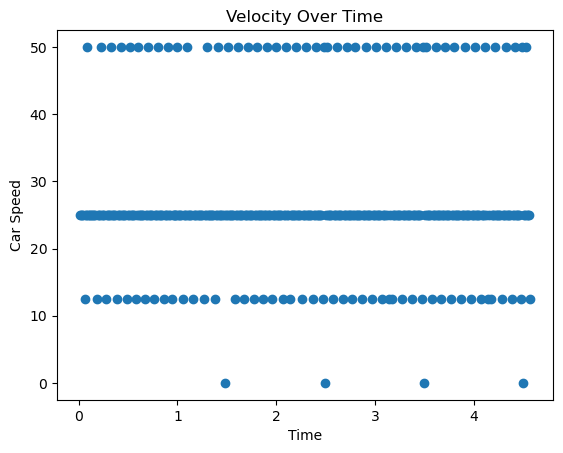

[(0.01, 25.0007), (0.02, 25.0055), (0.03, 24.9922), (0.04, 25.0012), (0.06, 12.5006), (0.07, 25.0017), (0.08, 25.006), (0.09, 49.9992), (0.1, 24.9975), (0.11, 25.0023), (0.12, 24.9975), (0.13, 25.0071), (0.14, 24.9932), (0.15, 25.0071), (0.16, 24.989), (0.17, 25.0071), (0.19, 12.4969), (0.2, 25.0071), (0.21, 24.9938), (0.22, 25.0028), (0.23, 50.0014), (0.24, 25.0028), (0.25, 24.9895), (0.26, 25.0076), (0.28, 12.4972), (0.29, 25.0076), (0.3, 24.9986), (0.31, 24.9944), (0.32, 25.0034), (0.33, 49.9935), (0.34, 25.0034), (0.35, 25.0082), (0.36, 24.9944), (0.37, 24.9992), (0.39, 12.4975), (0.4, 24.9992), (0.41, 25.004), (0.42, 25.0082), (0.43, 49.999), (0.44, 24.9907), (0.45, 25.004), (0.46, 24.9998), (0.47, 24.9998), (0.49, 12.4999), (0.5, 24.9998), (0.51, 25.0046), (0.52, 50.0002), (0.53, 25.0004), (0.54, 24.9913), (0.55, 25.0004), (0.56, 25.0053), (0.58, 12.4981), (0.59, 25.0011), (0.6, 50.0028), (0.61, 25.0059), (0.62, 24.9975), (0.63, 24.9933), (0.64, 25.0024), (0.65, 25.0073), (0.67, 

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


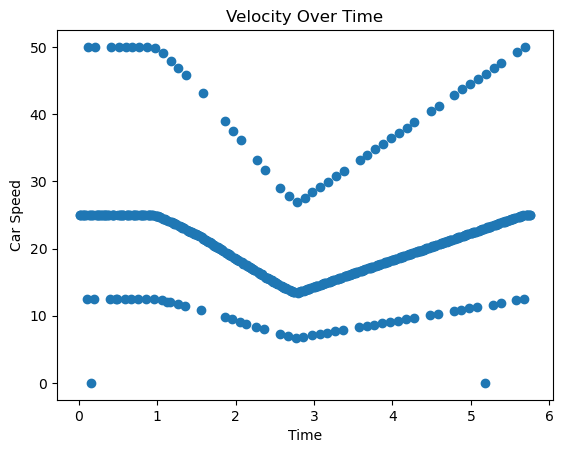

[(0.01, 24.9969), (0.02, 24.9969), (0.03, 25.0033), (0.05, 24.9989), (0.06, 24.9945), (0.07, 25.0009), (0.08, 25.0074), (0.09, 24.9933), (0.11, 12.5031), (0.12, 49.9971), (0.13, 24.9974), (0.14, 25.0038), (0.15, 0.0), (0.15, inf), (0.16, 24.9962), (0.17, 25.0027), (0.18, 25.0015), (0.2, 12.4969), (0.21, 50.0084), (0.22, 24.9928), (0.23, 24.9992), (0.24, 25.0057), (0.25, 24.9981), (0.26, 24.997), (0.27, 25.0046), (0.28, 24.9959), (0.3, 24.9991), (0.31, 25.0024), (0.32, 25.0089), (0.33, 24.9861), (0.34, 25.0002), (0.35, 25.0067), (0.36, 24.9991), (0.37, 24.9991), (0.38, 24.998), (0.4, 12.5022), (0.41, 49.9938), (0.42, 25.0034), (0.43, 25.0024), (0.44, 25.0024), (0.45, 24.9948), (0.47, 12.5039), (0.47, inf), (0.49, 12.5034), (0.5, 24.9927), (0.51, 49.9974), (0.52, 24.9982), (0.53, 25.0048), (0.54, 24.9972), (0.55, 25.0113), (0.56, 24.9952), (0.57, 25.0037), (0.59, 12.4938), (0.6, 49.9959), (0.61, 25.0148), (0.62, 25.0007), (0.63, 24.9922), (0.64, 24.9998), (0.65, 25.0053), (0.67, 12.4994)

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


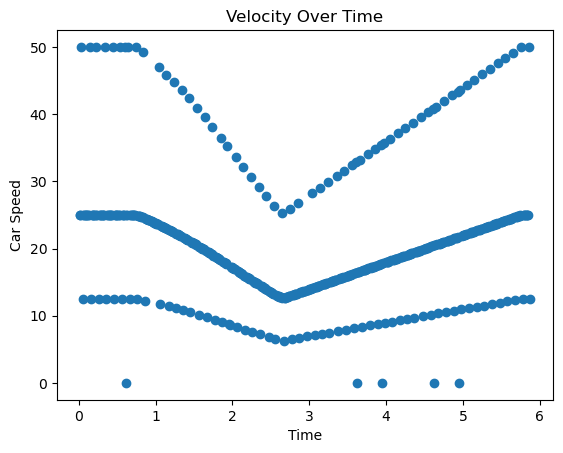

[(0.01, 24.9903), (0.02, 25.0001), (0.03, 49.9991), (0.05, 12.5044), (0.06, 24.9952), (0.07, 25.0001), (0.08, 25.0039), (0.09, 25.005), (0.1, 24.9914), (0.11, 24.9952), (0.12, 25.0001), (0.13, 25.005), (0.14, 49.9963), (0.16, 12.5025), (0.17, 25.0001), (0.18, 25.0001), (0.19, 25.0099), (0.2, 24.9963), (0.21, 24.9963), (0.22, 25.0012), (0.23, 49.9876), (0.24, 25.0099), (0.26, 12.4981), (0.27, 24.9914), (0.28, 25.0012), (0.29, 24.9963), (0.3, 24.9963), (0.31, 25.005), (0.32, 25.0012), (0.33, 24.9963), (0.34, 50.0012), (0.36, 12.5025), (0.37, 24.9914), (0.38, 25.005), (0.39, 25.005), (0.4, 25.0001), (0.41, 25.005), (0.42, 24.9914), (0.43, 25.0001), (0.44, 50.0002), (0.46, 12.5025), (0.47, 24.9816), (0.48, 25.005), (0.49, 25.0088), (0.5, 25.0001), (0.51, 25.0001), (0.52, 25.0039), (0.53, 24.9952), (0.54, 50.004), (0.56, 12.4976), (0.57, 25.0039), (0.58, 25.0001), (0.59, 25.0088), (0.6, 49.9904), (0.61, 25.0039), (0.62, 0.0), (0.63, 24.9952), (0.64, 49.9953), (0.66, 12.502), (0.67, 25.0137)

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


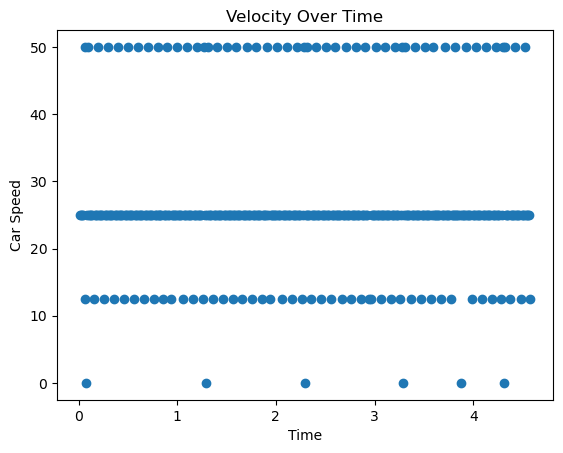

[(0.01, 25.0012), (0.02, 25.0), (0.03, 25.0006), (0.04, 25.0119), (0.06, 12.5003), (0.07, 50.0038), (0.08, 0.0), (0.09, 25.0012), (0.1, 50.0038), (0.11, 24.9926), (0.12, 25.0025), (0.13, 24.9926), (0.14, 24.9926), (0.16, 12.5013), (0.17, 24.9932), (0.18, 25.0032), (0.19, 25.0025), (0.2, 49.9977), (0.21, 25.0032), (0.22, 24.9939), (0.23, 24.9945), (0.24, 25.0038), (0.26, 12.4973), (0.27, 25.0045), (0.28, 24.9945), (0.29, 25.0052), (0.3, 49.9997), (0.31, 24.9952), (0.32, 25.0052), (0.33, 24.9958), (0.34, 25.0058), (0.36, 12.4976), (0.37, 25.0058), (0.38, 24.9952), (0.39, 24.9958), (0.4, 50.011), (0.41, 24.9958), (0.42, 25.0058), (0.43, 24.9952), (0.44, 25.0158), (0.46, 12.4926), (0.47, 25.0058), (0.48, 24.9958), (0.49, 25.0151), (0.5, 49.9917), (0.51, 24.9952), (0.52, 24.9958), (0.53, 25.0052), (0.54, 25.0158), (0.56, 12.4929), (0.57, 25.0052), (0.58, 24.9958), (0.59, 25.0058), (0.6, 50.011), (0.61, 24.9958), (0.62, 24.9859), (0.63, 25.0151), (0.64, 24.9958), (0.66, 12.5029), (0.67, 24.9

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


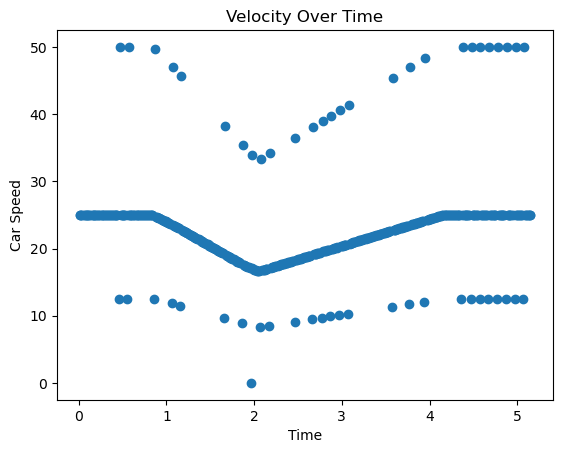

[(0.01, 25.0004), (0.02, 25.0054), (0.03, 24.9962), (0.04, 24.9971), (0.06, 24.9992), (0.07, 25.0063), (0.08, 25.0022), (0.09, 25.0022), (0.1, 24.993), (0.11, 25.0022), (0.12, 24.9971), (0.13, 25.0063), (0.15, 24.9971), (0.16, 25.0012), (0.17, 25.0012), (0.18, 25.0095), (0.19, 24.9871), (0.2, 25.0045), (0.21, 24.9954), (0.22, 25.0036), (0.23, 24.9987), (0.24, 24.9937), (0.26, 25.002), (0.27, 25.0012), (0.28, 25.0054), (0.29, 25.0004), (0.3, 24.9955), (0.31, 25.008), (0.32, 24.9989), (0.33, 25.0073), (0.34, 24.9933), (0.36, 25.0038), (0.37, 24.9968), (0.38, 25.0046), (0.39, 24.9913), (0.4, 25.004), (0.41, 24.9949), (0.42, 24.9944), (0.43, 25.0028), (0.44, 24.998), (0.46, 12.5011), (0.47, 49.9944), (0.48, 25.0012), (0.49, 25.0007), (0.5, 24.996), (0.51, 25.0002), (0.52, 25.0045), (0.53, 24.995), (0.55, 12.4997), (0.56, 25.008), (0.57, 49.9975), (0.58, 25.0025), (0.59, 25.0158), (0.6, 24.9845), (0.61, 25.0065), (0.62, 24.9928), (0.63, 24.9971), (0.64, 24.9968), (0.66, 25.0011), (0.67, 25.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


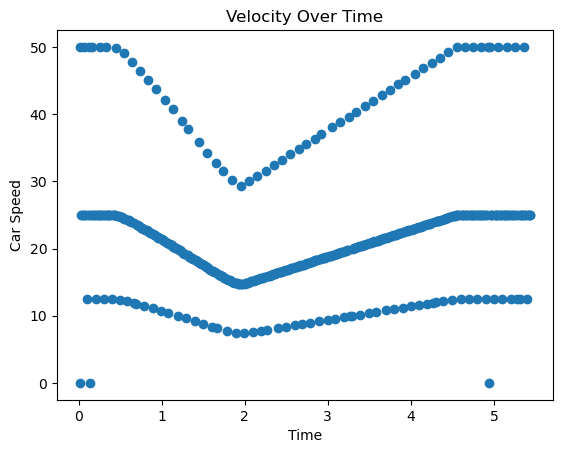

[(0.01, 50.0061), (0.02, 0.01), (0.03, 24.9982), (0.04, 24.9982), (0.05, 24.9982), (0.06, 50.0085), (0.07, 24.9982), (0.08, 25.0079), (0.1, 12.5052), (0.11, 24.9885), (0.12, 50.0061), (0.13, 0.0), (0.14, 25.0006), (0.15, 25.0079), (0.16, 49.9964), (0.17, 25.0103), (0.18, 24.9982), (0.19, 24.9982), (0.21, 12.5052), (0.22, 24.9982), (0.23, 24.9982), (0.24, 25.0103), (0.25, 24.9982), (0.26, 49.9964), (0.27, 24.9982), (0.28, 25.02), (0.3, 12.4942), (0.31, 25.0079), (0.32, 25.0006), (0.33, 50.0061), (0.34, 24.9885), (0.35, 25.0103), (0.36, 25.0079), (0.37, 24.9982), (0.38, 24.9982), (0.4, 12.5052), (0.41, 24.9982), (0.42, 24.9982), (0.43, 24.9885), (0.44, 24.9691), (0.45, 49.8727), (0.46, 24.906), (0.47, 24.8648), (0.48, 24.843), (0.5, 12.3899), (0.51, 24.729), (0.52, 24.6659), (0.53, 24.6125), (0.54, 49.0408), (0.55, 24.4209), (0.56, 24.3797), (0.58, 12.1486), (0.59, 24.2414), (0.6, 24.176), (0.61, 24.1105), (0.62, 24.0547), (0.63, 23.9869), (0.64, 47.7678), (0.66, 11.8978), (0.67, 23.7302

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


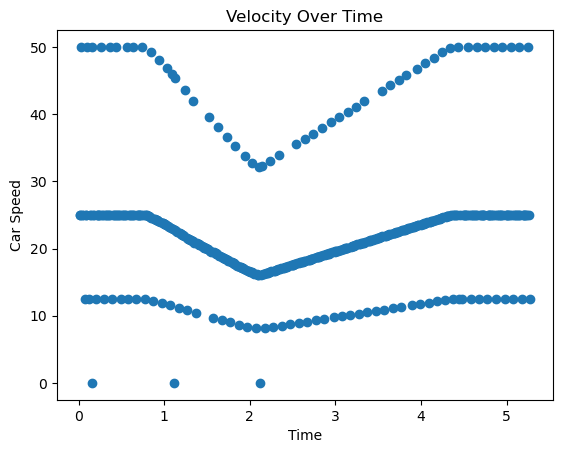

[(0.01, 24.9965), (0.02, 25.0027), (0.03, 50.0009), (0.04, 24.9965), (0.05, 25.0044), (0.07, 12.4982), (0.08, 24.9965), (0.09, 25.0044), (0.1, 49.9975), (0.12, 12.5013), (0.13, 24.9948), (0.13, inf), (0.14, 24.9932), (0.15, 0.0), (0.16, 50.0065), (0.17, 24.9993), (0.18, 24.9977), (0.2, 12.5019), (0.21, 24.996), (0.22, 24.9944), (0.23, 25.0006), (0.24, 24.999), (0.25, 25.0052), (0.26, 49.9993), (0.27, 25.002), (0.28, 25.0066), (0.3, 12.4994), (0.31, 24.9956), (0.32, 24.9956), (0.33, 25.0003), (0.34, 24.9987), (0.35, 25.0034), (0.36, 50.0023), (0.37, 24.9974), (0.39, 12.5011), (0.4, 25.0006), (0.41, 25.0054), (0.42, 24.9962), (0.43, 50.0055), (0.44, 24.9967), (0.45, 24.9939), (0.46, 24.9988), (0.47, 25.0038), (0.48, 25.001), (0.5, 12.4998), (0.51, 24.9983), (0.52, 25.002), (0.53, 25.0006), (0.54, 24.998), (0.55, 24.9967), (0.56, 50.0022), (0.58, 12.5028), (0.59, 24.9967), (0.6, 25.0018), (0.61, 25.0006), (0.62, 24.9993), (0.63, 24.9981), (0.64, 50.0002), (0.65, 25.0086), (0.67, 12.4966),

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


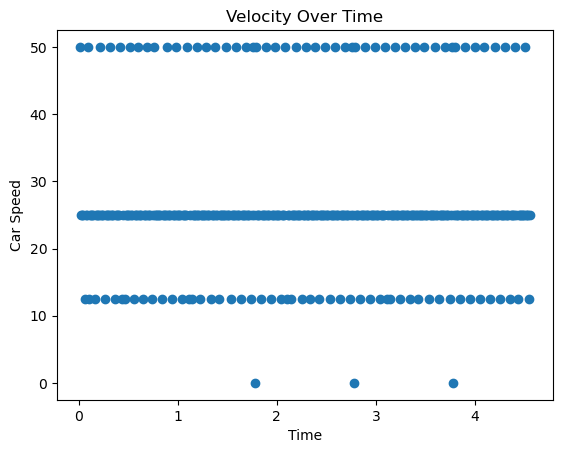

[(0.01, 50.0046), (0.02, 24.9951), (0.03, 25.005), (0.04, 25.0039), (0.06, 12.5014), (0.07, 24.9907), (0.08, 25.0006), (0.09, 50.0079), (0.11, 12.4981), (0.12, 24.9962), (0.12, inf), (0.13, 25.004), (0.14, 25.0019), (0.15, 25.0008), (0.17, 12.4994), (0.18, 24.9977), (0.19, 24.9966), (0.2, 25.0045), (0.21, 24.9925), (0.22, 50.0107), (0.23, 24.9884), (0.24, 24.9973), (0.25, 25.0043), (0.27, 12.5016), (0.28, 25.0013), (0.29, 25.0003), (0.3, 24.9984), (0.31, 24.9964), (0.32, 49.9971), (0.33, 25.0026), (0.34, 24.9998), (0.35, 24.9988), (0.37, 12.503), (0.38, 25.0051), (0.39, 24.9942), (0.4, 25.0024), (0.41, 25.0006), (0.42, 49.9958), (0.44, 12.503), (0.44, inf), (0.45, 25.0026), (0.47, 12.5009), (0.48, 24.9992), (0.49, 25.0083), (0.5, 24.9959), (0.51, 24.995), (0.52, 50.0043), (0.53, 24.9993), (0.54, 25.0077), (0.56, 12.4977), (0.57, 24.9946), (0.58, 25.0023), (0.59, 25.0), (0.6, 49.9964), (0.61, 25.0049), (0.62, 25.0034), (0.63, 24.992), (0.65, 12.5003), (0.66, 24.9979), (0.67, 25.0072), (

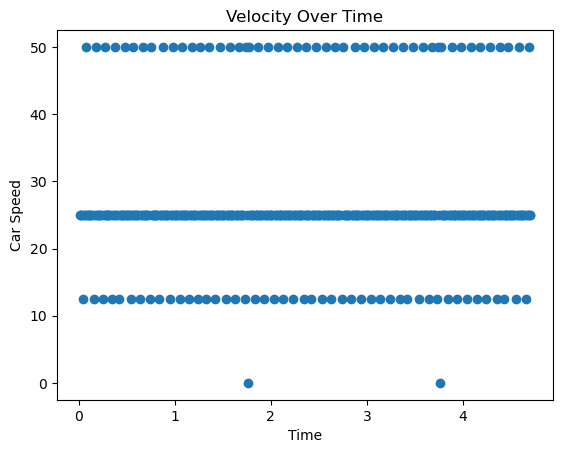

[(0.01, 25.0054), (0.02, 24.9914), (0.03, 25.0069), (0.05, 12.4996), (0.06, 24.9992), (0.07, 25.0069), (0.08, 49.9935), (0.09, 25.0069), (0.1, 24.9944), (0.11, 24.9944), (0.12, 25.0006), (0.13, 25.0021), (0.14, 25.0021), (0.16, 12.4972), (0.17, 24.9958), (0.18, 50.0058), (0.19, 24.9958), (0.2, 24.9958), (0.21, 25.0036), (0.22, 24.9974), (0.23, 24.9974), (0.25, 12.5026), (0.26, 25.0036), (0.27, 49.9962), (0.28, 25.0051), (0.29, 24.9926), (0.3, 24.9989), (0.31, 24.9989), (0.32, 24.9989), (0.33, 25.0004), (0.35, 12.5033), (0.36, 24.9941), (0.37, 25.0004), (0.38, 49.9945), (0.39, 25.0082), (0.4, 24.9879), (0.42, 12.5041), (0.43, 24.9957), (0.44, 25.0019), (0.45, 25.0034), (0.46, 24.9957), (0.47, 25.0034), (0.48, 49.9944), (0.49, 25.0034), (0.5, 24.9987), (0.51, 24.9972), (0.52, 24.9987), (0.54, 12.5033), (0.55, 24.9909), (0.56, 25.0065), (0.57, 50.0006), (0.58, 25.0065), (0.59, 24.994), (0.6, 25.0019), (0.61, 25.0003), (0.62, 24.9956), (0.64, 12.5048), (0.65, 25.0019), (0.66, 24.9956), (0.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


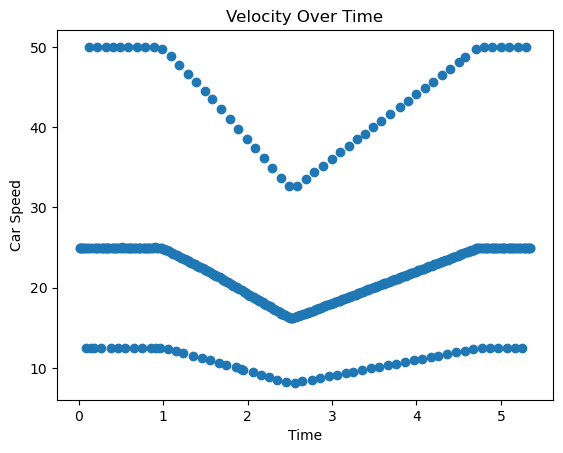

[(0.01, 25.0), (0.02, 25.0), (0.03, 25.0), (0.04, 25.0), (0.05, 25.0), (0.06, 25.0), (0.07, 25.0), (0.09, 12.5), (0.1, 25.0), (0.11, 25.0), (0.12, 50.0), (0.13, 25.0), (0.15, 12.5), (0.15, inf), (0.16, 25.0), (0.18, 12.5), (0.19, 25.0), (0.2, 25.0), (0.21, 25.0), (0.22, 50.01), (0.23, 24.99), (0.24, 25.0), (0.26, 12.5), (0.27, 25.0), (0.28, 25.0), (0.29, 25.0), (0.3, 25.0), (0.31, 25.0), (0.32, 50.0001), (0.33, 25.0), (0.34, 25.0), (0.35, 25.0), (0.36, 25.0), (0.38, 12.5), (0.39, 25.0), (0.4, 25.0001), (0.41, 50.0001), (0.42, 25.0), (0.43, 25.0), (0.44, 25.0), (0.45, 25.0), (0.47, 12.5), (0.48, 25.0), (0.49, 50.0001), (0.5, 25.0), (0.51, 25.01), (0.52, 24.99), (0.53, 25.0), (0.55, 12.5), (0.56, 25.0), (0.57, 25.0), (0.58, 50.0), (0.59, 25.0), (0.6, 25.0), (0.61, 25.0), (0.62, 25.0), (0.63, 25.0), (0.65, 12.5), (0.66, 25.0), (0.67, 25.0), (0.68, 25.0), (0.69, 50.0), (0.7, 25.0), (0.71, 25.0), (0.72, 25.0), (0.73, 25.0), (0.75, 12.5), (0.76, 25.0), (0.77, 25.0), (0.78, 25.0), (0.79, 50.0

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


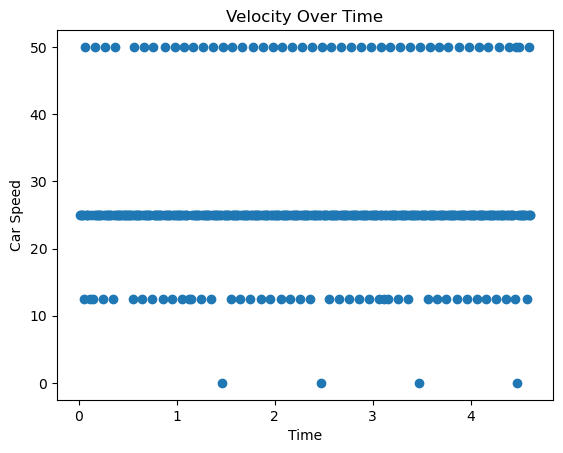

[(0.01, 24.9984), (0.02, 24.9984), (0.03, 25.0041), (0.04, 25.0098), (0.06, 12.4951), (0.07, 50.0026), (0.08, 24.9959), (0.09, 25.0041), (0.1, 24.9984), (0.12, 12.5021), (0.13, 25.0041), (0.13, inf), (0.15, 12.4992), (0.16, 24.9984), (0.17, 50.0026), (0.18, 24.9928), (0.19, 24.9984), (0.2, 24.9984), (0.21, 25.0041), (0.22, 24.9984), (0.23, 25.0041), (0.25, 12.5005), (0.26, 24.9984), (0.27, 50.0026), (0.28, 25.001), (0.29, 24.9984), (0.3, 24.9928), (0.31, 25.0067), (0.32, 24.9984), (0.33, 24.9928), (0.35, 12.5033), (0.36, 25.001), (0.37, 49.9912), (0.38, 25.0067), (0.39, 25.0067), (0.4, 24.9953), (0.41, 25.001), (0.42, 25.001), (0.43, 25.001), (0.45, 24.9981), (0.46, 25.0035), (0.47, 24.9953), (0.48, 25.0061), (0.49, 24.9922), (0.5, 25.0118), (0.51, 24.9947), (0.52, 24.9947), (0.53, 24.9973), (0.55, 12.5015), (0.56, 24.9999), (0.57, 50.005), (0.58, 25.0051), (0.59, 24.9938), (0.6, 25.002), (0.61, 24.999), (0.62, 24.999), (0.63, 24.9986), (0.65, 12.4965), (0.66, 25.0096), (0.67, 49.9881)

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


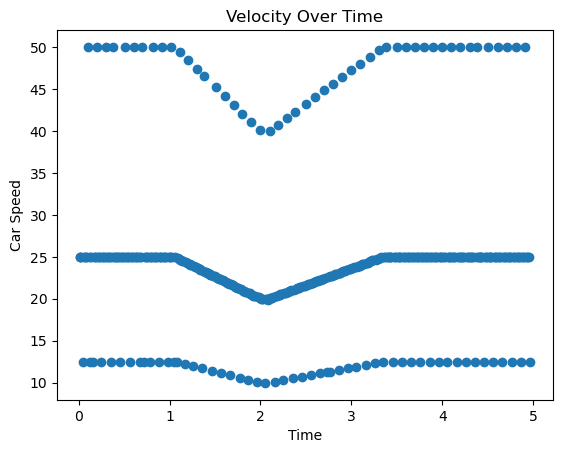

[(0.01, 24.9973), (0.02, 25.0043), (0.03, 25.0043), (0.05, 12.4987), (0.06, 24.9972), (0.07, 25.0043), (0.08, 24.9902), (0.09, 25.0042), (0.1, 50.0015), (0.12, 12.5021), (0.12, inf), (0.13, 25.0042), (0.14, 25.0042), (0.16, 12.5021), (0.17, 24.9971), (0.18, 25.0042), (0.19, 24.9971), (0.2, 49.9941), (0.21, 25.0111), (0.22, 24.9971), (0.23, 24.9971), (0.25, 12.502), (0.26, 24.9899), (0.27, 25.0041), (0.28, 24.997), (0.29, 25.0111), (0.3, 49.9939), (0.31, 24.9899), (0.32, 25.011), (0.33, 25.004), (0.34, 24.997), (0.36, 12.4984), (0.37, 24.997), (0.38, 50.0008), (0.39, 25.0039), (0.4, 24.997), (0.41, 25.0039), (0.42, 25.0039), (0.43, 24.9968), (0.44, 25.0039), (0.46, 12.4984), (0.47, 24.9968), (0.48, 25.0039), (0.49, 25.0039), (0.5, 24.9968), (0.51, 50.0006), (0.52, 24.9968), (0.53, 24.9968), (0.54, 25.0038), (0.55, 25.0038), (0.57, 12.4984), (0.58, 25.0038), (0.59, 24.9968), (0.6, 24.9967), (0.61, 50.0075), (0.62, 24.9967), (0.63, 25.0038), (0.64, 25.0037), (0.65, 24.9896), (0.67, 12.498

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


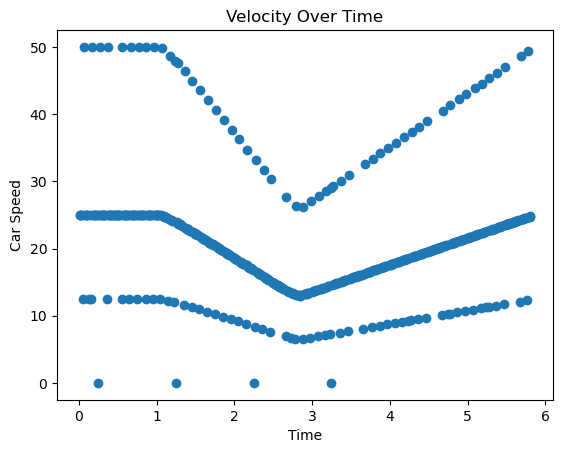

[(0.01, 24.9969), (0.02, 25.0091), (0.03, 24.9872), (0.04, 25.002), (0.06, 12.4997), (0.07, 50.0039), (0.08, 24.9923), (0.09, 25.002), (0.1, 25.0045), (0.11, 24.9948), (0.13, 12.5022), (0.13, inf), (0.14, 25.007), (0.16, 12.4987), (0.17, 49.9947), (0.18, 24.9999), (0.19, 24.9999), (0.2, 25.0096), (0.21, 24.9928), (0.23, 25.0012), (0.24, 24.9953), (0.25, 0.0), (0.26, 25.0024), (0.27, 50.0003), (0.28, 25.005), (0.29, 24.9979), (0.3, 24.9953), (0.31, 24.9979), (0.32, 24.9979), (0.33, 25.0004), (0.34, 25.0004), (0.36, 12.4989), (0.37, 50.0034), (0.38, 25.003), (0.39, 25.003), (0.4, 24.9933), (0.41, 25.003), (0.42, 24.9959), (0.43, 25.0055), (0.44, 24.9959), (0.46, 25.002), (0.47, 24.9984), (0.48, 25.0081), (0.49, 24.9913), (0.5, 25.001), (0.51, 25.0081), (0.52, 24.9939), (0.53, 24.9913), (0.55, 12.5018), (0.56, 49.9975), (0.57, 25.0036), (0.58, 25.0062), (0.59, 25.0062), (0.6, 24.9868), (0.61, 25.0062), (0.62, 24.9894), (0.63, 25.0087), (0.65, 12.4995), (0.66, 24.9991), (0.67, 50.0033), (0

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


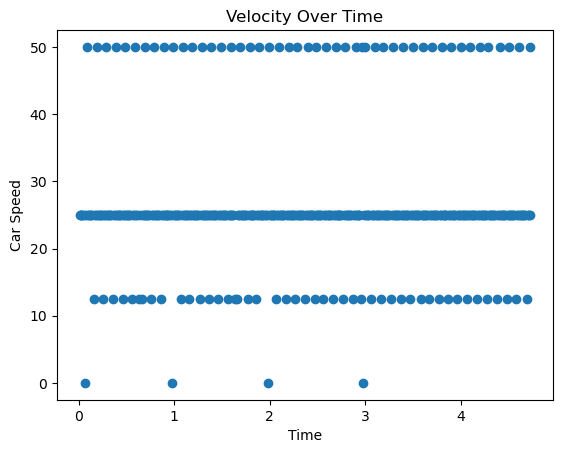

[(0.01, 25.0083), (0.02, 24.9912), (0.03, 25.0034), (0.04, 25.0006), (0.06, 24.997), (0.07, 0.0), (0.08, 25.0009), (0.09, 50.0009), (0.1, 24.9934), (0.11, 25.0127), (0.12, 24.9896), (0.13, 25.0014), (0.14, 24.9993), (0.16, 12.5023), (0.17, 25.0026), (0.18, 24.9939), (0.19, 49.9969), (0.2, 25.0031), (0.21, 25.002), (0.22, 25.0077), (0.23, 24.9919), (0.24, 24.9977), (0.26, 12.4984), (0.27, 25.0026), (0.28, 25.0017), (0.29, 50.0076), (0.3, 24.9919), (0.31, 25.0052), (0.32, 24.9973), (0.33, 25.0034), (0.34, 24.9959), (0.36, 12.5011), (0.37, 25.0016), (0.38, 24.9941), (0.39, 50.0004), (0.4, 24.9995), (0.41, 25.0132), (0.42, 24.9915), (0.43, 24.9982), (0.44, 25.0049), (0.46, 12.4988), (0.47, 25.0043), (0.48, 24.9971), (0.49, 50.0004), (0.5, 25.0036), (0.51, 24.9964), (0.52, 25.0034), (0.53, 25.0033), (0.54, 24.9962), (0.56, 12.4981), (0.57, 25.0033), (0.58, 24.9963), (0.59, 50.007), (0.6, 25.0037), (0.61, 24.9897), (0.63, 12.502), (0.64, 24.9971), (0.64, inf), (0.66, 12.4987), (0.67, 25.0119

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


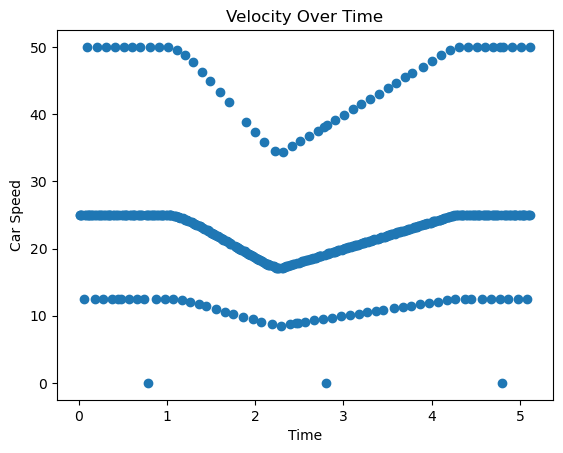

[(0.01, 24.9988), (0.02, 25.0026), (0.03, 25.0003), (0.04, 25.0), (0.06, 12.5005), (0.07, 24.9957), (0.08, 25.0032), (0.09, 49.9991), (0.1, 24.9992), (0.11, 25.0027), (0.12, 24.9998), (0.13, 24.9968), (0.14, 25.0005), (0.15, 25.0009), (0.16, 25.0014), (0.18, 12.4988), (0.19, 25.0024), (0.2, 24.9987), (0.21, 49.9994), (0.22, 24.9998), (0.23, 25.0005), (0.24, 25.0013), (0.25, 25.0012), (0.26, 24.9977), (0.28, 12.5015), (0.29, 24.9985), (0.3, 24.9995), (0.31, 50.0001), (0.32, 24.9998), (0.33, 25.0019), (0.34, 24.9976), (0.35, 24.9988), (0.36, 25.0027), (0.38, 12.4997), (0.39, 25.0008), (0.4, 24.9986), (0.41, 50.0004), (0.42, 24.9983), (0.43, 25.0007), (0.45, 12.4998), (0.46, 25.0021), (0.46, inf), (0.48, 12.5004), (0.49, 25.0025), (0.5, 24.9987), (0.51, 50.0018), (0.52, 25.0031), (0.53, 24.9984), (0.54, 25.0002), (0.55, 25.0002), (0.57, 12.4996), (0.58, 24.9992), (0.59, 25.0029), (0.6, 49.9985), (0.61, 24.9992), (0.62, 25.0002), (0.63, 25.0011), (0.64, 24.9974), (0.66, 12.5015), (0.67, 24

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


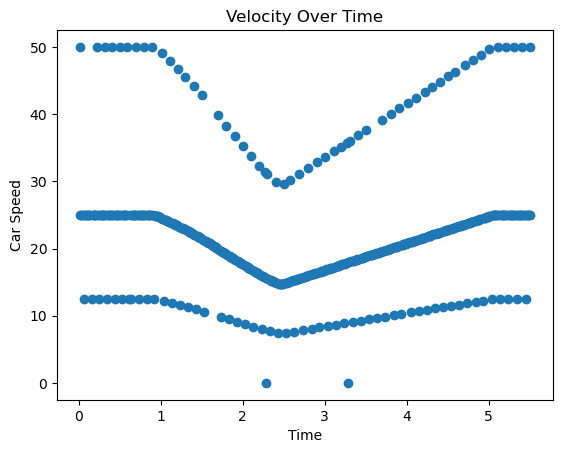

[(0.01, 24.9982), (0.02, 50.0063), (0.03, 24.9981), (0.04, 25.0082), (0.06, 12.5041), (0.07, 24.9881), (0.08, 24.9982), (0.09, 25.0082), (0.1, 24.9982), (0.11, 24.9982), (0.13, 25.0032), (0.13, inf), (0.14, 24.9983), (0.16, 12.5041), (0.17, 24.9982), (0.18, 24.9982), (0.19, 25.0082), (0.2, 24.9982), (0.21, 24.9981), (0.22, 50.0059), (0.23, 24.9979), (0.25, 12.4988), (0.26, 25.0075), (0.27, 24.9972), (0.28, 24.9969), (0.29, 24.9966), (0.3, 25.0061), (0.31, 24.9957), (0.32, 49.9998), (0.33, 25.0041), (0.35, 12.4967), (0.36, 25.0028), (0.37, 25.002), (0.38, 25.0014), (0.39, 25.0006), (0.4, 24.9998), (0.41, 49.9975), (0.42, 24.9975), (0.44, 12.5034), (0.45, 24.9961), (0.46, 25.0054), (0.47, 24.9947), (0.48, 25.0039), (0.49, 24.9933), (0.5, 49.9944), (0.51, 25.0112), (0.53, 12.4953), (0.54, 25.01), (0.55, 24.9994), (0.56, 24.9987), (0.57, 25.0081), (0.58, 24.9875), (0.59, 49.9933), (0.61, 12.5028), (0.61, inf), (0.62, 24.9946), (0.64, 12.502), (0.65, 25.0034), (0.66, 25.0028), (0.67, 24.992

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


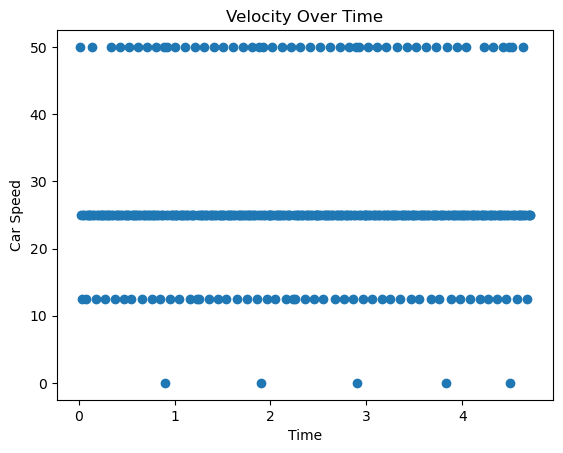

[(0.01, 49.9989), (0.02, 25.0006), (0.04, 12.4999), (0.05, 24.9972), (0.06, 25.0011), (0.06, inf), (0.08, 12.5007), (0.09, 24.9981), (0.1, 25.0011), (0.11, 24.9986), (0.12, 25.0016), (0.13, 25.0009), (0.14, 49.9972), (0.15, 24.9999), (0.16, 24.9948), (0.18, 12.5026), (0.19, 24.9981), (0.2, 25.0021), (0.22, 24.9998), (0.23, 24.9975), (0.23, inf), (0.24, 25.0056), (0.25, 24.9995), (0.26, 24.998), (0.28, 12.5032), (0.29, 24.9988), (0.3, 24.9947), (0.31, 25.0041), (0.32, 25.0), (0.33, 25.0048), (0.34, 50.002), (0.35, 24.9925), (0.36, 25.002), (0.38, 12.4966), (0.39, 25.0074), (0.4, 25.0082), (0.41, 24.9946), (0.42, 24.9953), (0.43, 49.9962), (0.44, 25.0104), (0.45, 25.0017), (0.47, 12.4964), (0.48, 24.9985), (0.49, 24.9985), (0.5, 24.9945), (0.51, 25.009), (0.52, 24.9914), (0.53, 50.0021), (0.55, 12.501), (0.56, 25.0029), (0.57, 24.9941), (0.58, 24.999), (0.59, 24.9999), (0.6, 24.996), (0.61, 25.0009), (0.62, 49.995), (0.63, 24.999), (0.64, 24.999), (0.66, 12.5), (0.67, 25.005), (0.68, 25.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


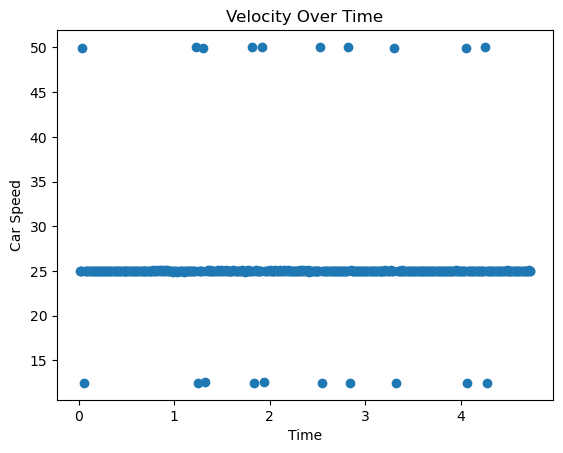

[(0.01, 25.0009), (0.02, 25.0001), (0.03, 25.0009), (0.04, 49.9903), (0.06, 12.5054), (0.07, 25.0001), (0.08, 25.0009), (0.09, 25.0009), (0.1, 25.0017), (0.11, 25.0017), (0.13, 25.0025), (0.14, 24.9942), (0.15, 24.9934), (0.16, 25.005), (0.17, 24.9959), (0.18, 25.0058), (0.19, 25.0067), (0.2, 24.9975), (0.21, 24.9984), (0.22, 24.9992), (0.23, 24.9992), (0.24, 25.0009), (0.26, 24.9963), (0.27, 25.0026), (0.28, 25.0134), (0.29, 24.9944), (0.3, 24.9944), (0.31, 24.9952), (0.32, 24.9961), (0.33, 25.007), (0.34, 24.9979), (0.36, 24.9988), (0.37, 25.0096), (0.38, 25.0006), (0.39, 24.9915), (0.4, 25.0114), (0.41, 24.9933), (0.42, 24.9933), (0.43, 25.0042), (0.44, 25.0042), (0.46, 25.0006), (0.47, 24.997), (0.48, 24.997), (0.49, 25.0069), (0.5, 24.9979), (0.51, 24.9979), (0.52, 24.9979), (0.53, 24.9979), (0.55, 24.9979), (0.56, 24.9979), (0.57, 24.9979), (0.58, 24.997), (0.59, 24.996), (0.6, 25.006), (0.61, 25.0051), (0.62, 24.9951), (0.64, 24.9974), (0.65, 25.0014), (0.66, 24.9997), (0.67, 24

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


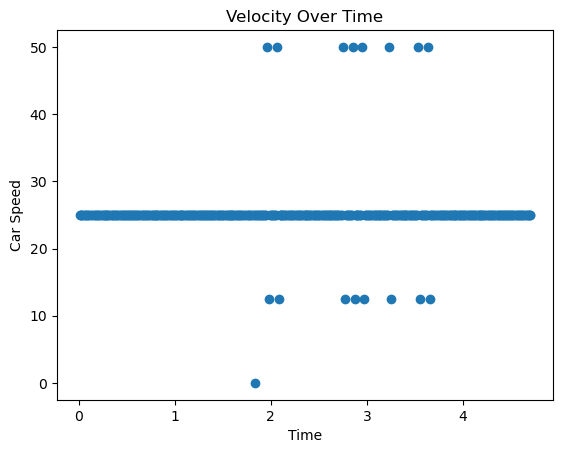

[(0.01, 25.0294), (0.02, 24.968), (0.03, 25.0279), (0.04, 24.9664), (0.06, 24.9944), (0.07, 25.0239), (0.08, 25.0223), (0.09, 24.957), (0.1, 25.0184), (0.11, 25.0152), (0.13, 24.9802), (0.14, 25.0089), (0.14, nan), (0.16, 25.0034), (0.17, 25.0003), (0.18, 24.9963), (0.19, 24.994), (0.2, 25.0541), (0.21, 24.9885), (0.22, 24.9853), (0.24, 24.9818), (0.25, 25.0392), (0.26, 24.9751), (0.27, 25.0337), (0.28, 24.9688), (0.29, 25.0282), (0.3, 24.9641), (0.31, 25.0227), (0.32, 25.0196), (0.34, 24.9847), (0.35, 25.0117), (0.36, 25.0094), (0.37, 25.0055), (0.38, 25.0039), (0.39, 25.0007), (0.4, 24.9992), (0.41, 24.996), (0.43, 24.9937), (0.44, 24.9913), (0.45, 24.9906), (0.46, 24.9898), (0.47, 25.0511), (0.48, 24.9898), (0.49, 24.9906), (0.5, 24.9921), (0.51, 24.9937), (0.52, 24.9953), (0.53, 24.9984), (0.55, 25.0027), (0.56, 25.0078), (0.57, 25.0117), (0.58, 25.0157), (0.59, 24.9578), (0.6, 25.0243), (0.61, 24.9688), (0.62, 25.0345), (0.63, 24.9782), (0.65, 25.0173), (0.66, 24.9948), (0.67, 25.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


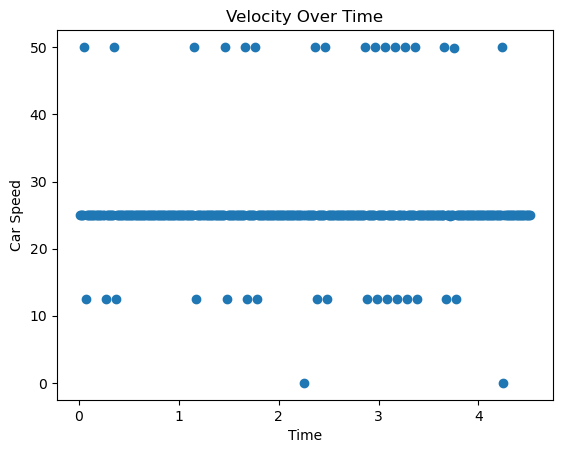

[(0.01, 24.9932), (0.02, 24.9951), (0.03, 25.0297), (0.04, 24.996), (0.05, 49.9949), (0.07, 12.4989), (0.08, 24.9998), (0.09, 24.9998), (0.1, 25.0017), (0.11, 25.0017), (0.12, 25.0026), (0.13, 25.0045), (0.14, 24.9703), (0.15, 25.0045), (0.17, 25.0068), (0.18, 25.0082), (0.19, 24.975), (0.2, 25.0092), (0.21, 25.011), (0.22, 24.9768), (0.24, 25.0129), (0.25, 24.9797), (0.25, inf), (0.27, 12.4908), (0.28, 25.0167), (0.29, 24.9834), (0.3, 25.0176), (0.31, 24.9853), (0.32, 25.0204), (0.33, 24.9881), (0.34, 24.9891), (0.35, 50.016), (0.37, 12.4964), (0.38, 24.9956), (0.39, 24.9966), (0.4, 25.0336), (0.41, 24.9675), (0.42, 25.0032), (0.43, 25.0069), (0.44, 25.0088), (0.46, 24.9975), (0.47, 24.9854), (0.48, 25.0239), (0.49, 24.9938), (0.5, 24.9985), (0.51, 25.0042), (0.52, 25.008), (0.53, 24.9821), (0.54, 25.0202), (0.56, 24.9967), (0.57, 25.0066), (0.58, 24.9812), (0.59, 24.9897), (0.6, 24.9972), (0.61, 25.0057), (0.62, 25.0152), (0.63, 24.9911), (0.64, 25.0005), (0.65, 25.0119), (0.66, 24.9

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


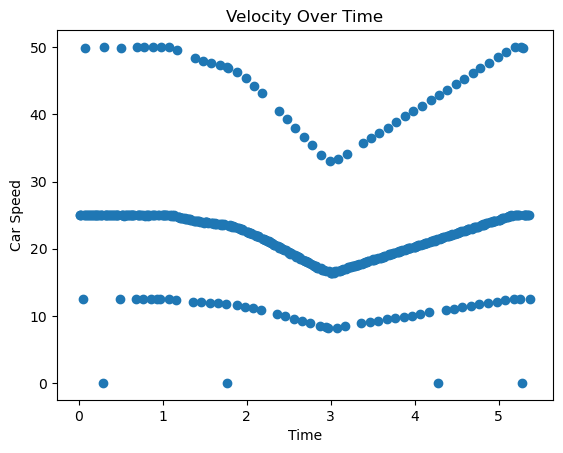

[(0.01, 25.0572), (0.02, 24.9764), (0.03, 24.9764), (0.05, 12.5286), (0.06, 24.9831), (0.07, 49.9594), (0.08, 24.9831), (0.09, 25.0572), (0.1, 24.9831), (0.11, 24.9831), (0.12, 24.9831), (0.13, 24.9831), (0.15, 25.0168), (0.16, 24.9831), (0.17, 25.0505), (0.18, 24.9831), (0.19, 24.9764), (0.2, 25.0505), (0.21, 24.9764), (0.22, 24.9696), (0.23, 25.0505), (0.24, 24.9696), (0.26, 25.0034), (0.27, 24.9629), (0.28, 25.0371), (0.29, 0.0), (0.3, 49.9866), (0.31, 25.0237), (0.32, 24.9495), (0.33, 25.0237), (0.34, 25.0104), (0.35, 25.0104), (0.36, 25.0104), (0.37, 25.0037), (0.39, 24.9937), (0.4, 24.9903), (0.41, 24.9836), (0.42, 24.9836), (0.43, 25.0515), (0.44, 24.9703), (0.45, 24.9636), (0.46, 25.0449), (0.47, 24.957), (0.49, 12.5158), (0.5, 49.9752), (0.51, 25.0249), (0.52, 25.0183), (0.53, 25.0116), (0.54, 24.937), (0.55, 25.0116), (0.56, 25.005), (0.57, 25.0116), (0.59, 25.0017), (0.6, 24.9984), (0.61, 25.005), (0.62, 24.9984), (0.63, 24.9984), (0.64, 24.9984), (0.65, 24.9984), (0.66, 24.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


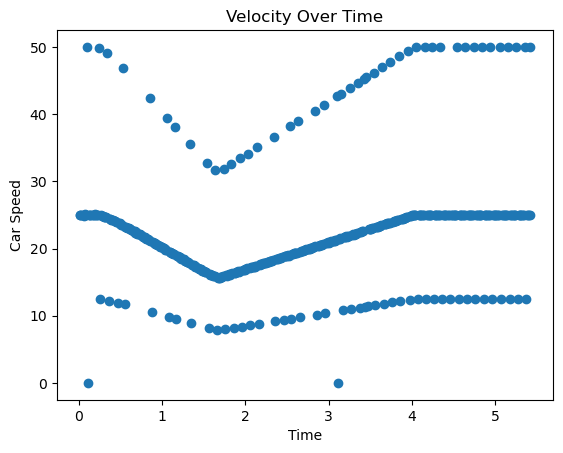

[(0.01, 24.9988), (0.02, 25.0017), (0.03, 24.9988), (0.05, 24.9988), (0.06, 24.9032), (0.07, 25.0944), (0.08, 24.9958), (0.09, 24.9958), (0.1, 49.9917), (0.11, 0.0), (0.12, 24.9929), (0.13, 24.9958), (0.14, 24.9929), (0.16, 24.9915), (0.17, 24.99), (0.18, 24.99), (0.19, 24.99), (0.2, 25.0857), (0.21, 24.9871), (0.22, 24.9842), (0.23, 24.9842), (0.24, 49.8639), (0.26, 12.4877), (0.27, 24.9725), (0.28, 24.871), (0.29, 24.8681), (0.3, 24.7666), (0.31, 24.7579), (0.32, 24.755), (0.33, 24.6506), (0.34, 49.1882), (0.36, 12.2674), (0.37, 24.4303), (0.38, 24.4246), (0.39, 24.3202), (0.4, 24.3116), (0.41, 24.21), (0.43, 24.1014), (0.44, 24.0914), (0.45, 23.9842), (0.45, inf), (0.47, 11.937), (0.48, 23.7697), (0.49, 23.7612), (0.5, 23.6568), (0.51, 23.5524), (0.52, 23.544), (0.53, 46.868), (0.55, 11.7114), (0.56, 23.2224), (0.57, 23.2113), (0.58, 23.1097), (0.59, 23.0986), (0.6, 22.9942), (0.61, 22.887), (0.62, 22.8815), (0.63, 22.7744), (0.65, 22.6672), (0.66, 22.5547), (0.67, 22.5492), (0.68, 

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


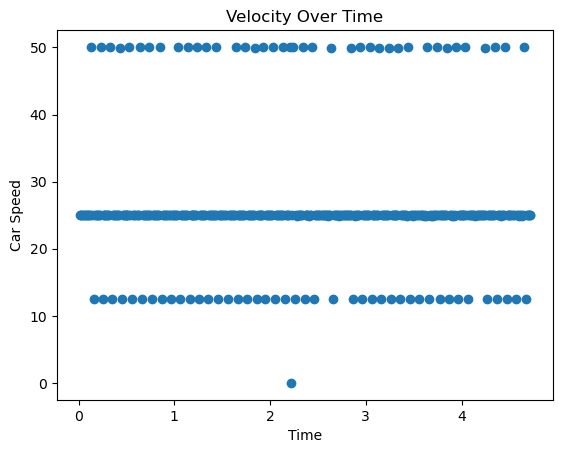

[(0.01, 25.0139), (0.02, 24.986), (0.03, 25.0158), (0.05, 25.0037), (0.06, 24.9907), (0.07, 24.9917), (0.08, 25.0224), (0.09, 24.9946), (0.1, 24.9955), (0.11, 24.9974), (0.12, 24.9984), (0.13, 50.0006), (0.14, 25.0022), (0.16, 12.5016), (0.17, 25.0051), (0.18, 25.006), (0.19, 24.9776), (0.2, 25.0089), (0.21, 25.0089), (0.22, 24.9814), (0.23, 50.0245), (0.25, 12.4917), (0.26, 25.0127), (0.27, 24.9852), (0.28, 25.0137), (0.29, 24.9852), (0.3, 25.0137), (0.31, 24.9833), (0.32, 25.0118), (0.33, 49.9921), (0.35, 12.5044), (0.36, 24.9785), (0.37, 25.006), (0.38, 25.0041), (0.39, 25.0032), (0.4, 25.0012), (0.41, 24.9993), (0.42, 24.9974), (0.43, 49.9891), (0.45, 12.4958), (0.46, 25.0196), (0.47, 24.9879), (0.48, 25.0158), (0.49, 24.9841), (0.5, 25.011), (0.51, 25.011), (0.52, 24.9783), (0.53, 50.0105), (0.54, 25.0024), (0.56, 12.5002), (0.57, 24.9986), (0.58, 24.9976), (0.59, 24.9948), (0.61, 25.007), (0.62, 24.989), (0.62, nan), (0.63, 25.0173), (0.64, 49.9987), (0.66, 12.4907), (0.67, 25.00

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


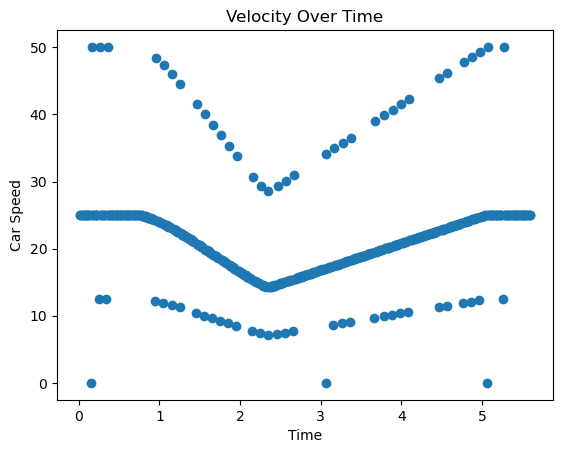

[(0.01, 25.0621), (0.02, 24.9695), (0.04, 24.9702), (0.05, 25.0646), (0.06, 24.972), (0.07, 24.9724), (0.08, 24.9731), (0.09, 25.0672), (0.1, 24.9742), (0.11, 24.9753), (0.12, 25.0689), (0.14, 24.9765), (0.15, 0.0), (0.16, 50.0489), (0.17, 24.9789), (0.18, 24.9796), (0.19, 24.98), (0.2, 25.074), (0.21, 24.981), (0.22, 24.9818), (0.23, 24.9821), (0.25, 12.4912), (0.26, 49.9657), (0.27, 25.0765), (0.28, 24.9832), (0.29, 24.9832), (0.3, 24.9828), (0.31, 24.9832), (0.32, 24.9825), (0.34, 12.5379), (0.35, 24.9818), (0.36, 49.9632), (0.37, 24.9814), (0.38, 24.9807), (0.39, 24.9803), (0.4, 25.0736), (0.41, 24.98), (0.42, 24.9796), (0.43, 24.9792), (0.45, 25.0253), (0.46, 24.9785), (0.47, 25.0715), (0.48, 24.9774), (0.49, 24.9774), (0.5, 24.9771), (0.51, 25.0704), (0.52, 24.9763), (0.53, 24.976), (0.54, 25.0693), (0.56, 24.9754), (0.57, 24.9749), (0.58, 25.0679), (0.59, 24.9742), (0.6, 24.9742), (0.61, 24.9738), (0.62, 25.0664), (0.63, 24.9731), (0.64, 24.9727), (0.66, 25.019), (0.67, 24.9717)

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


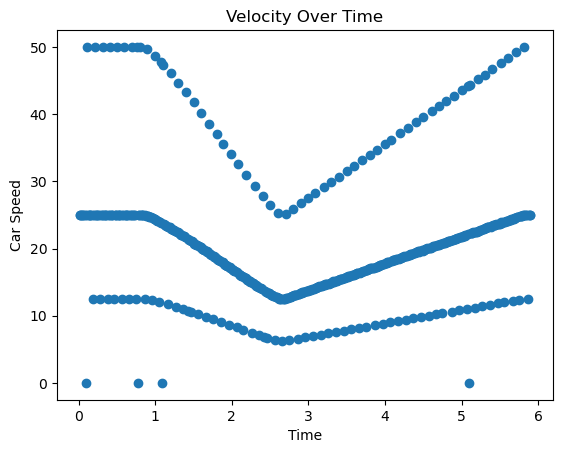

[(0.01, 24.9954), (0.02, 25.0052), (0.03, 25.0052), (0.04, 24.9788), (0.05, 25.0052), (0.06, 24.9954), (0.08, 25.0052), (0.09, 25.0052), (0.1, 0.01), (0.11, 49.9938), (0.12, 25.0052), (0.13, 25.0052), (0.14, 24.9886), (0.15, 25.0052), (0.16, 25.0052), (0.18, 12.4993), (0.19, 25.0052), (0.2, 24.9886), (0.21, 50.0037), (0.22, 25.0151), (0.23, 24.9886), (0.24, 24.9985), (0.25, 24.9886), (0.26, 25.0151), (0.28, 12.4993), (0.29, 24.9985), (0.3, 24.9985), (0.31, 49.997), (0.32, 24.9985), (0.33, 25.0084), (0.34, 24.9985), (0.35, 24.9985), (0.36, 25.0084), (0.38, 12.4993), (0.39, 24.9922), (0.4, 24.9985), (0.41, 49.9906), (0.42, 25.0084), (0.43, 25.0084), (0.44, 24.9922), (0.46, 12.5042), (0.47, 24.9922), (0.48, 25.0084), (0.49, 24.9922), (0.5, 50.0103), (0.51, 24.9922), (0.52, 24.9922), (0.53, 25.002), (0.54, 25.0084), (0.56, 12.501), (0.57, 24.9922), (0.58, 25.002), (0.59, 50.0041), (0.6, 24.9922), (0.61, 25.002), (0.62, 25.002), (0.63, 25.002), (0.64, 24.9862), (0.66, 12.501), (0.67, 25.011

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


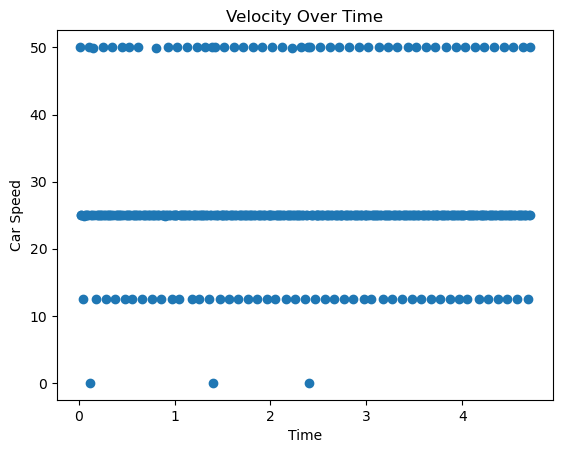

[(0.01, 50.0537), (0.02, 24.9965), (0.03, 25.0032), (0.05, 12.505), (0.06, 24.9428), (0.07, 25.0167), (0.08, 25.0302), (0.09, 24.9496), (0.1, 25.0302), (0.11, 50.0), (0.12, 0.0), (0.13, 24.9699), (0.14, 25.0436), (0.15, 49.9533), (0.16, 25.0504), (0.18, 12.4917), (0.19, 24.9766), (0.2, 25.0571), (0.21, 24.9834), (0.22, 24.9834), (0.23, 24.9834), (0.24, 24.9766), (0.25, 50.0405), (0.26, 24.9834), (0.27, 24.9766), (0.29, 12.5252), (0.3, 24.9834), (0.31, 24.9699), (0.32, 25.0504), (0.33, 24.9699), (0.34, 24.9699), (0.35, 50.0067), (0.36, 25.0369), (0.38, 12.4816), (0.39, 25.0302), (0.4, 24.9564), (0.41, 25.0234), (0.42, 25.0234), (0.43, 24.9496), (0.44, 25.0234), (0.45, 50.0267), (0.46, 25.01), (0.48, 12.468), (0.49, 25.01), (0.5, 25.0032), (0.51, 25.0032), (0.52, 25.0032), (0.53, 49.993), (0.54, 24.9898), (0.56, 12.4983), (0.57, 25.0639), (0.58, 24.9898), (0.59, 24.9898), (0.6, 24.9898), (0.61, 24.9831), (0.62, 50.0537), (0.63, 24.9831), (0.64, 24.9898), (0.66, 12.4949), (0.67, 24.9898),

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


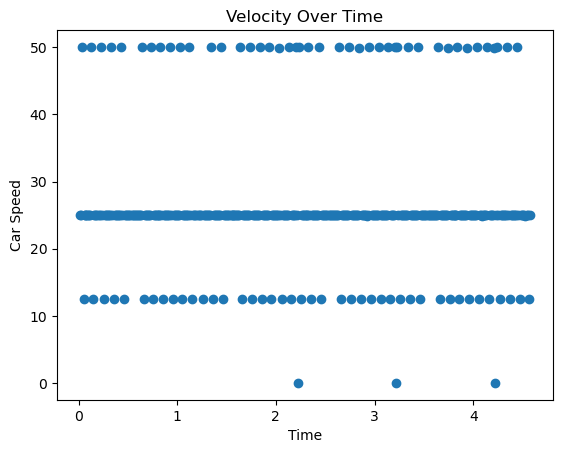

[(0.01, 24.996), (0.02, 25.006), (0.03, 50.002), (0.05, 12.498), (0.06, 24.997), (0.07, 25.006), (0.08, 24.997), (0.09, 25.006), (0.1, 24.997), (0.11, 24.997), (0.12, 24.997), (0.13, 49.9953), (0.15, 12.5035), (0.16, 24.9984), (0.17, 25.007), (0.18, 24.9884), (0.19, 25.0083), (0.21, 24.9984), (0.22, 25.0083), (0.22, inf), (0.23, 50.0084), (0.24, 24.9902), (0.26, 12.5042), (0.27, 25.0001), (0.28, 25.0001), (0.29, 24.9984), (0.3, 25.0001), (0.31, 25.0001), (0.32, 25.0001), (0.33, 50.0003), (0.34, 24.9923), (0.36, 12.505), (0.37, 25.0001), (0.38, 25.0001), (0.39, 25.0001), (0.4, 25.0001), (0.41, 25.0083), (0.42, 24.9902), (0.43, 50.0003), (0.44, 25.0083), (0.46, 12.4951), (0.47, 24.9984), (0.48, 25.0083), (0.49, 24.9984), (0.5, 24.9984), (0.51, 24.9984), (0.52, 24.9984), (0.54, 25.0026), (0.55, 24.997), (0.56, 24.997), (0.57, 25.007), (0.58, 24.997), (0.59, 24.987), (0.6, 25.006), (0.61, 24.996), (0.62, 25.006), (0.63, 25.0054), (0.64, 50.0009), (0.66, 12.4977), (0.67, 24.9955), (0.68, 24

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


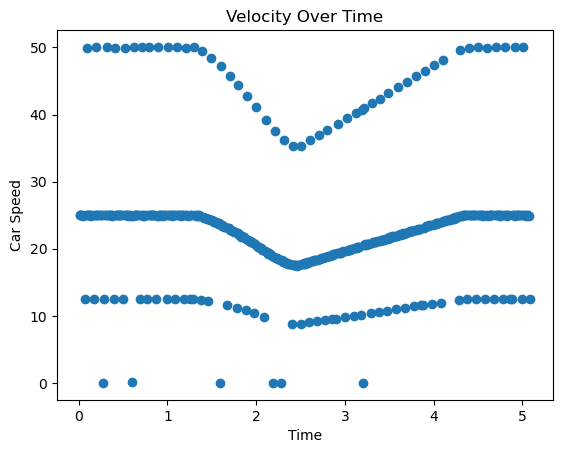

[(0.01, 25.014), (0.02, 25.0104), (0.03, 25.014), (0.04, 25.014), (0.05, 24.9245), (0.07, 12.5088), (0.08, 25.0176), (0.09, 49.9458), (0.1, 25.0176), (0.11, 25.0213), (0.12, 25.0176), (0.13, 25.0213), (0.14, 24.9245), (0.15, 25.014), (0.17, 12.507), (0.18, 25.014), (0.19, 50.0171), (0.2, 25.0031), (0.21, 25.0031), (0.22, 24.9958), (0.24, 24.9922), (0.25, 24.9886), (0.26, 24.9814), (0.27, 0.01), (0.27, inf), (0.29, 12.4871), (0.3, 24.9706), (0.31, 24.967), (0.32, 50.0166), (0.33, 25.0461), (0.34, 24.9527), (0.35, 25.0389), (0.36, 25.0354), (0.37, 24.9384), (0.38, 25.0283), (0.4, 12.5124), (0.41, 49.9453), (0.42, 25.0106), (0.43, 25.007), (0.44, 25.0035), (0.45, 25.0), (0.46, 24.9965), (0.47, 24.9895), (0.48, 24.9859), (0.5, 12.5381), (0.51, 24.9754), (0.52, 49.9404), (0.53, 25.0553), (0.54, 24.958), (0.55, 25.0449), (0.56, 24.9441), (0.58, 25.0311), (0.59, 24.9303), (0.6, 0.1), (0.61, 24.9234), (0.62, 50.0141), (0.63, 24.9968), (0.64, 24.9934), (0.65, 24.9866), (0.66, 25.0739), (0.67, 2

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


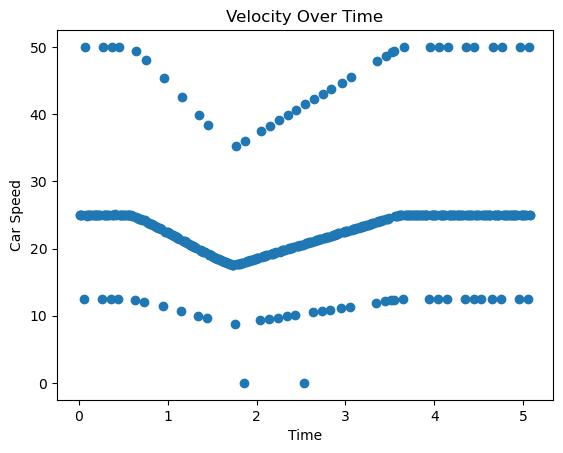

[(0.01, 24.9771), (0.02, 24.9771), (0.03, 24.9822), (0.04, 24.9926), (0.06, 12.5391), (0.07, 50.0006), (0.08, 25.0081), (0.09, 24.9277), (0.1, 25.0184), (0.11, 25.0236), (0.12, 24.9433), (0.13, 25.034), (0.14, 25.0392), (0.16, 24.959), (0.17, 25.0548), (0.18, 24.9694), (0.19, 25.0652), (0.2, 24.9798), (0.21, 24.9903), (0.22, 24.9903), (0.23, 24.9955), (0.24, 25.0008), (0.26, 12.5056), (0.27, 50.0277), (0.28, 24.9314), (0.29, 25.027), (0.3, 25.027), (0.31, 24.9472), (0.32, 25.0375), (0.33, 25.048), (0.34, 24.9577), (0.36, 12.4842), (0.37, 50.0321), (0.38, 24.9789), (0.39, 24.9842), (0.4, 24.9895), (0.41, 25.0796), (0.42, 25.0), (0.44, 12.4603), (0.45, 50.0213), (0.46, 25.016), (0.47, 25.0266), (0.48, 24.9473), (0.49, 25.0372), (0.5, 24.9633), (0.51, 25.0532), (0.52, 24.9847), (0.54, 24.9954), (0.55, 25.0169), (0.56, 24.938), (0.57, 24.9434), (0.58, 24.9596), (0.59, 24.9596), (0.6, 24.8863), (0.61, 24.8918), (0.63, 12.4039), (0.64, 49.4646), (0.65, 24.6514), (0.66, 24.5734), (0.67, 24.57

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


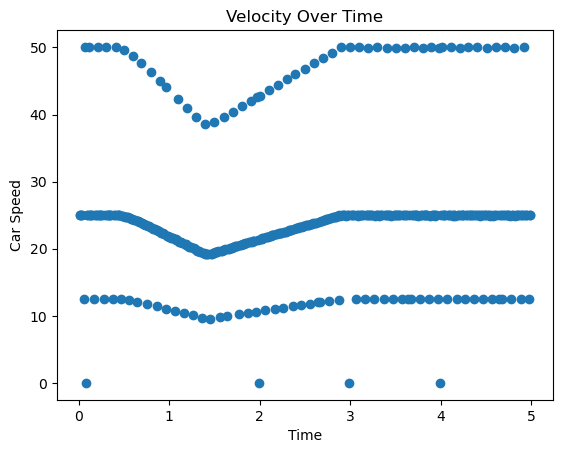

[(0.01, 25.0055), (0.02, 24.9956), (0.03, 25.0055), (0.04, 24.9956), (0.06, 12.5028), (0.07, 50.0011), (0.08, 0.0), (0.09, 24.9953), (0.1, 25.0055), (0.11, 49.9908), (0.12, 25.0055), (0.13, 24.9953), (0.14, 25.0055), (0.15, 25.0053), (0.17, 12.4977), (0.18, 24.9953), (0.19, 25.0055), (0.2, 25.0053), (0.21, 49.9907), (0.22, 25.0053), (0.23, 25.0053), (0.24, 24.9953), (0.25, 24.9955), (0.26, 25.0053), (0.28, 12.4977), (0.29, 24.9955), (0.3, 50.0106), (0.31, 24.9955), (0.32, 24.9955), (0.33, 25.0053), (0.34, 24.9955), (0.35, 24.9955), (0.36, 25.0053), (0.38, 12.5027), (0.39, 24.9955), (0.4, 24.9955), (0.41, 50.0009), (0.42, 25.0054), (0.43, 24.9855), (0.44, 24.9756), (0.45, 24.9562), (0.47, 12.4679), (0.48, 24.9159), (0.49, 24.8865), (0.5, 49.6828), (0.51, 24.7964), (0.52, 24.7471), (0.53, 24.7073), (0.54, 24.6575), (0.56, 12.3039), (0.57, 24.5675), (0.58, 24.499), (0.59, 24.4484), (0.6, 48.7376), (0.61, 24.2891), (0.62, 24.2201), (0.64, 12.0898), (0.65, 24.1199), (0.66, 24.0608), (0.67, 

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time
C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


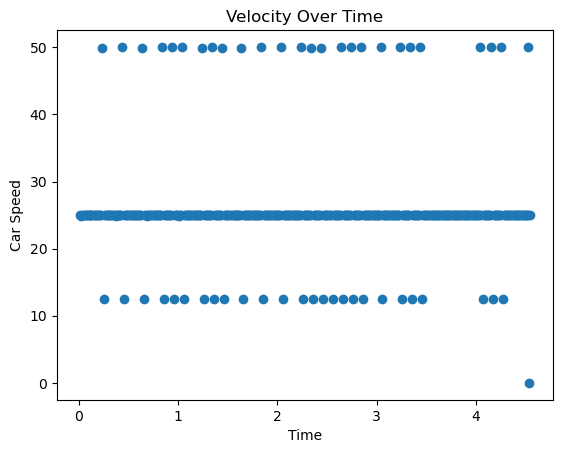

[(0.01, 25.0253), (0.02, 24.9323), (0.03, 25.031), (0.05, 24.9888), (0.06, 25.0453), (0.07, 24.9495), (0.08, 25.051), (0.09, 24.9581), (0.1, 25.0596), (0.11, 24.9667), (0.12, 24.9696), (0.13, 25.0683), (0.14, 24.9783), (0.16, 24.9842), (0.17, 24.99), (0.18, 24.9929), (0.19, 24.9988), (0.2, 25.0017), (0.21, 25.0076), (0.22, 25.0076), (0.23, 25.0164), (0.24, 49.9462), (0.26, 12.5141), (0.27, 25.0342), (0.28, 24.9418), (0.29, 25.0462), (0.3, 24.9538), (0.31, 25.0582), (0.32, 24.9688), (0.33, 24.9749), (0.34, 25.0793), (0.36, 24.9962), (0.37, 25.0084), (0.38, 24.9226), (0.39, 25.0269), (0.4, 25.0331), (0.41, 24.9506), (0.42, 25.058), (0.43, 24.9725), (0.44, 49.9735), (0.46, 12.5021), (0.47, 25.017), (0.48, 25.0266), (0.49, 24.9449), (0.5, 25.0524), (0.51, 24.9676), (0.53, 24.9873), (0.54, 25.0038), (0.55, 25.0203), (0.56, 25.027), (0.57, 24.9494), (0.58, 25.0571), (0.59, 24.973), (0.6, 24.9866), (0.61, 25.0036), (0.62, 25.0139), (0.63, 25.0311), (0.64, 49.916), (0.66, 12.5381), (0.67, 25.0

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


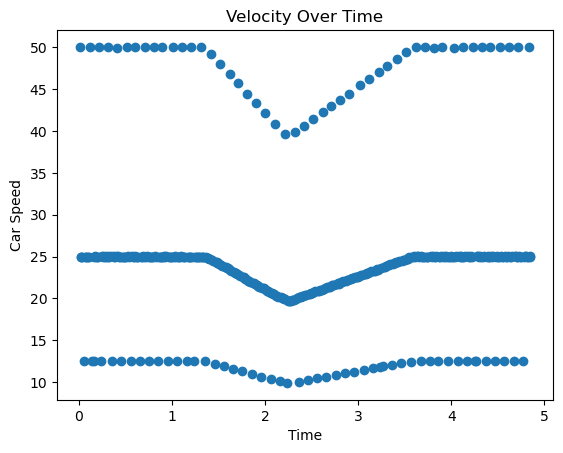

[(0.01, 49.9938), (0.02, 25.0052), (0.03, 24.9886), (0.04, 25.0052), (0.06, 12.5026), (0.07, 24.9985), (0.08, 25.0052), (0.09, 24.9886), (0.1, 25.0052), (0.11, 24.9985), (0.12, 50.0037), (0.14, 12.5026), (0.14, inf), (0.16, 12.4993), (0.17, 24.9886), (0.18, 25.0151), (0.19, 24.9985), (0.2, 24.9985), (0.21, 24.9886), (0.22, 49.997), (0.24, 12.4993), (0.25, 25.0151), (0.26, 24.9922), (0.27, 25.0151), (0.28, 24.9823), (0.29, 24.9985), (0.3, 25.0084), (0.31, 50.0069), (0.32, 24.9922), (0.33, 24.9985), (0.34, 25.0084), (0.36, 12.4961), (0.37, 25.0084), (0.38, 24.9922), (0.39, 24.9922), (0.4, 25.0182), (0.41, 49.9844), (0.42, 25.0182), (0.43, 24.9922), (0.44, 25.002), (0.46, 12.501), (0.47, 25.002), (0.48, 24.9922), (0.49, 24.9961), (0.5, 25.002), (0.51, 25.002), (0.52, 49.9882), (0.53, 25.0119), (0.54, 25.002), (0.56, 12.4981), (0.57, 25.0119), (0.58, 24.9862), (0.59, 24.9961), (0.6, 25.0119), (0.61, 49.9922), (0.62, 25.006), (0.63, 24.9961), (0.64, 25.006), (0.66, 12.4953), (0.67, 25.006),

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


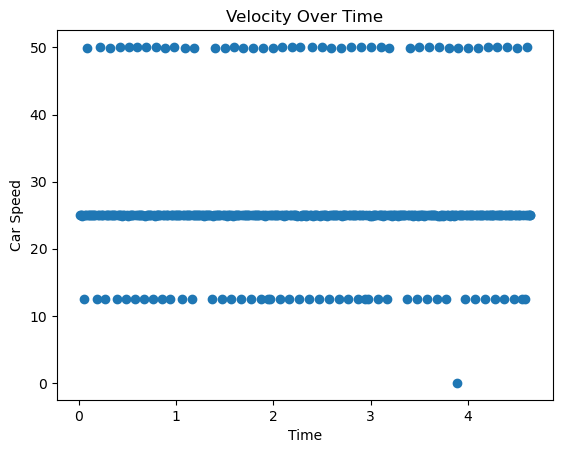

[(0.01, 25.0162), (0.02, 25.0188), (0.03, 25.0214), (0.04, 24.9479), (0.06, 12.5133), (0.07, 25.0286), (0.08, 24.9558), (0.09, 49.9949), (0.1, 25.0391), (0.11, 24.9657), (0.12, 25.0437), (0.13, 24.9703), (0.14, 24.9729), (0.15, 25.0503), (0.16, 24.9769), (0.17, 24.9795), (0.19, 12.5278), (0.2, 24.9828), (0.21, 24.9835), (0.22, 50.0469), (0.23, 24.9868), (0.24, 24.9881), (0.25, 24.9887), (0.27, 12.494), (0.28, 24.9881), (0.29, 24.9881), (0.3, 24.9868), (0.31, 25.0614), (0.32, 49.9683), (0.33, 24.9823), (0.34, 24.9806), (0.35, 25.054), (0.36, 24.9764), (0.37, 25.0494), (0.39, 12.4857), (0.4, 24.9688), (0.41, 25.0412), (0.42, 49.9981), (0.43, 24.9568), (0.44, 25.029), (0.45, 24.9502), (0.46, 25.0225), (0.47, 25.0191), (0.49, 12.5079), (0.5, 25.0124), (0.51, 24.9336), (0.52, 50.0081), (0.53, 24.9991), (0.54, 25.0715), (0.55, 24.9923), (0.56, 24.989), (0.58, 12.4929), (0.59, 24.9823), (0.6, 50.0298), (0.61, 24.9716), (0.62, 25.0435), (0.63, 24.9638), (0.64, 24.9596), (0.65, 25.0308), (0.67,

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


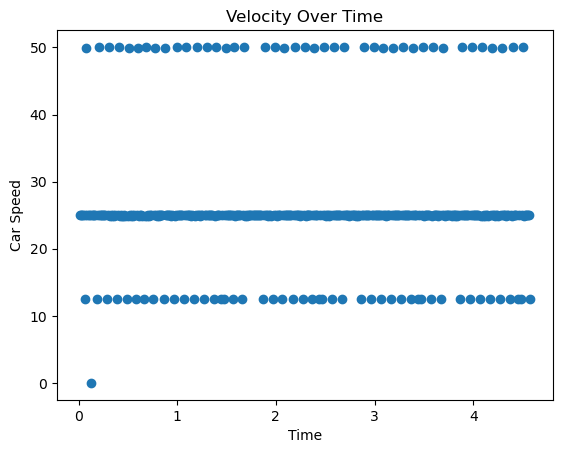

[(0.01, 24.9675), (0.02, 24.9672), (0.03, 25.0629), (0.04, 24.9664), (0.06, 12.483), (0.07, 25.0617), (0.08, 49.9301), (0.09, 25.0606), (0.11, 24.9639), (0.12, 25.0595), (0.13, 0.0), (0.13, inf), (0.14, 24.9626), (0.15, 25.0584), (0.16, 24.9618), (0.17, 25.0576), (0.19, 12.4805), (0.2, 24.9607), (0.21, 50.0164), (0.22, 24.9596), (0.23, 25.0553), (0.24, 24.9588), (0.25, 25.0546), (0.26, 24.958), (0.27, 25.0539), (0.29, 12.4786), (0.3, 25.0531), (0.31, 50.0089), (0.32, 24.9558), (0.33, 25.0516), (0.34, 24.955), (0.35, 25.0508), (0.36, 24.9543), (0.37, 25.0502), (0.39, 12.4768), (0.4, 25.0495), (0.41, 50.0018), (0.42, 24.9524), (0.43, 25.0483), (0.44, 24.9518), (0.45, 24.9515), (0.46, 25.0474), (0.47, 24.9509), (0.49, 12.5234), (0.5, 24.9504), (0.51, 49.9962), (0.52, 25.0459), (0.53, 24.9495), (0.54, 25.0455), (0.55, 24.9491), (0.56, 25.0451), (0.58, 12.4743), (0.59, 25.0447), (0.6, 49.9925), (0.61, 24.9478), (0.62, 25.0438), (0.63, 25.0437), (0.64, 24.9472), (0.66, 12.5216), (0.67, 24.94

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


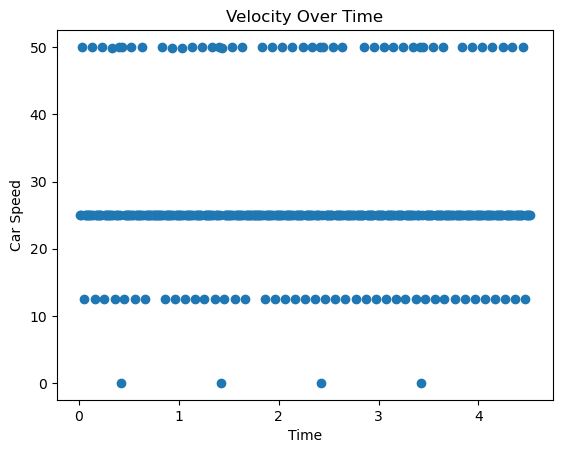

[(0.01, 24.9651), (0.02, 25.0429), (0.03, 50.0074), (0.05, 12.4823), (0.06, 25.0429), (0.07, 24.9658), (0.08, 25.0442), (0.09, 24.9677), (0.1, 24.9689), (0.11, 25.048), (0.12, 24.9727), (0.13, 50.0313), (0.14, 24.9815), (0.16, 12.4926), (0.17, 24.9897), (0.18, 24.9954), (0.19, 25.0011), (0.2, 25.008), (0.21, 25.0156), (0.22, 25.0244), (0.23, 49.9992), (0.25, 12.4878), (0.26, 24.9869), (0.27, 24.9984), (0.28, 25.0111), (0.29, 25.0244), (0.3, 24.9615), (0.31, 25.0531), (0.32, 24.9909), (0.33, 49.9537), (0.34, 25.0402), (0.36, 12.4899), (0.37, 24.9978), (0.38, 25.0152), (0.39, 25.0333), (0.4, 49.9707), (0.41, 25.0143), (0.42, 0.0), (0.43, 50.01), (0.45, 12.4983), (0.46, 24.9407), (0.47, 25.0372), (0.48, 24.9828), (0.49, 25.0032), (0.5, 25.025), (0.51, 24.9712), (0.52, 50.0087), (0.53, 25.0382), (0.54, 24.9856), (0.56, 12.5045), (0.57, 24.9582), (0.58, 24.9817), (0.59, 25.0059), (0.6, 25.0302), (0.61, 24.9807), (0.62, 25.0064), (0.63, 50.0133), (0.64, 25.0078), (0.66, 12.4803), (0.67, 24.9

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: invalid value encountered in double_scalars
  speed = dist_between_frames/time


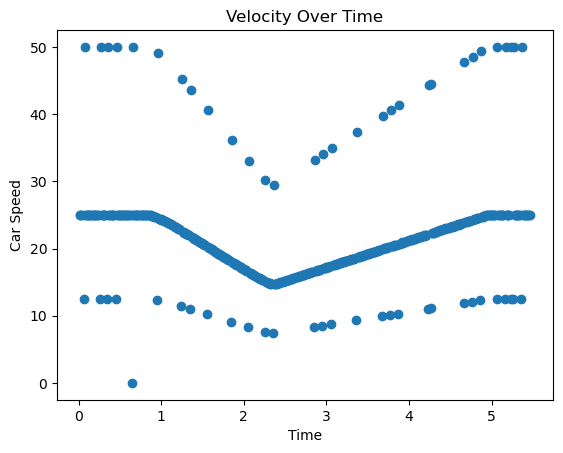

[(0.01, 24.9948), (0.02, 24.9948), (0.04, 24.9904), (0.04, nan), (0.06, 12.5163), (0.07, 49.9719), (0.08, 25.0237), (0.09, 24.9771), (0.1, 25.0237), (0.11, 24.9682), (0.12, 25.0148), (0.13, 25.0148), (0.14, 25.0148), (0.16, 24.9826), (0.17, 25.006), (0.18, 25.006), (0.19, 24.9972), (0.2, 24.9972), (0.21, 24.9972), (0.22, 24.9972), (0.23, 25.0353), (0.24, 24.9883), (0.26, 12.4942), (0.27, 50.0059), (0.28, 24.9795), (0.29, 25.0265), (0.3, 24.9707), (0.31, 25.0177), (0.32, 25.0177), (0.34, 12.4853), (0.35, 25.0177), (0.36, 49.9706), (0.37, 25.0088), (0.38, 25.0), (0.39, 25.0088), (0.4, 25.0), (0.41, 25.0088), (0.42, 25.0), (0.43, 25.0), (0.45, 12.5044), (0.46, 50.0001), (0.47, 24.9618), (0.48, 25.0), (0.49, 25.0088), (0.5, 25.0), (0.51, 25.0088), (0.52, 25.0088), (0.53, 25.0), (0.54, 25.0088), (0.56, 24.9853), (0.57, 25.0088), (0.58, 25.0088), (0.59, 25.0088), (0.6, 25.0088), (0.61, 24.9618), (0.63, 25.0133), (0.64, 25.0088), (0.65, 0.0), (0.66, 49.9794), (0.67, 25.0177), (0.68, 24.9618),

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


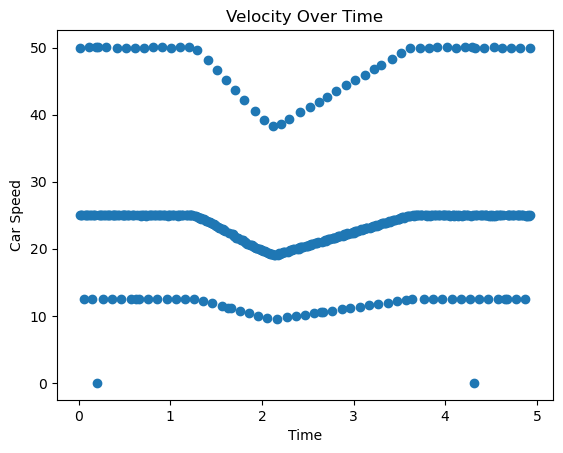

[(0.01, 49.9608), (0.02, 25.0489), (0.03, 24.9804), (0.04, 24.9804), (0.06, 12.4942), (0.07, 25.041), (0.08, 24.9804), (0.09, 24.9884), (0.1, 24.9804), (0.11, 50.0213), (0.12, 24.9804), (0.13, 25.041), (0.15, 12.4902), (0.16, 24.9804), (0.17, 25.041), (0.18, 24.9804), (0.19, 50.0213), (0.2, 0.0), (0.21, 50.0133), (0.22, 24.9804), (0.23, 24.9804), (0.24, 25.033), (0.25, 24.9804), (0.27, 12.4902), (0.28, 25.033), (0.29, 24.9724), (0.3, 50.0133), (0.31, 24.9804), (0.32, 25.033), (0.33, 24.9724), (0.34, 24.9724), (0.36, 12.5205), (0.37, 24.9645), (0.38, 25.033), (0.39, 24.9724), (0.4, 25.0251), (0.41, 25.0171), (0.42, 49.9736), (0.43, 25.0092), (0.44, 25.0092), (0.46, 12.5006), (0.47, 24.9933), (0.48, 24.9854), (0.49, 25.0384), (0.5, 24.9695), (0.51, 25.0226), (0.52, 49.9683), (0.53, 24.9989), (0.54, 24.991), (0.55, 24.983), (0.57, 12.5183), (0.58, 25.0286), (0.59, 24.9593), (0.6, 25.005), (0.61, 49.9942), (0.63, 12.4946), (0.64, 25.0353), (0.64, inf), (0.66, 12.5098), (0.67, 25.0196), (0.

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


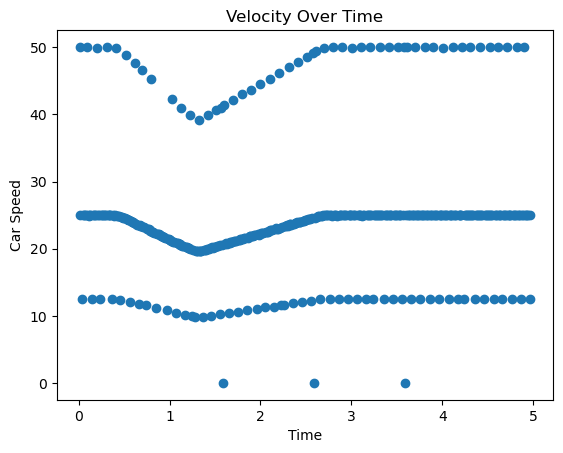

[(0.01, 50.0164), (0.02, 25.0082), (0.04, 12.4541), (0.05, 25.0082), (0.06, 25.0084), (0.07, 25.0082), (0.08, 25.0079), (0.09, 50.0164), (0.1, 25.0079), (0.11, 24.9082), (0.12, 25.0077), (0.13, 25.0079), (0.15, 12.504), (0.16, 25.0077), (0.17, 25.0074), (0.18, 25.0074), (0.19, 25.0074), (0.2, 49.9144), (0.21, 25.0067), (0.22, 25.007), (0.24, 12.5034), (0.25, 25.0065), (0.26, 25.0063), (0.27, 25.006), (0.28, 25.006), (0.29, 25.0058), (0.3, 25.0054), (0.31, 50.0104), (0.32, 25.0048), (0.33, 25.0048), (0.34, 25.0044), (0.35, 25.004), (0.37, 12.502), (0.38, 25.0037), (0.39, 24.9034), (0.4, 25.0032), (0.41, 49.9056), (0.42, 24.8025), (0.43, 24.9022), (0.44, 24.8021), (0.46, 12.4009), (0.47, 24.7016), (0.48, 24.7014), (0.49, 24.6012), (0.5, 24.6011), (0.51, 24.6009), (0.52, 48.8013), (0.53, 24.4005), (0.54, 24.3003), (0.55, 24.2003), (0.57, 12.1001), (0.58, 24.1002), (0.59, 24.0001), (0.6, 24.0), (0.61, 23.9), (0.62, 47.7), (0.63, 23.7), (0.64, 23.6), (0.66, 11.8), (0.67, 23.6001), (0.68, 23

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


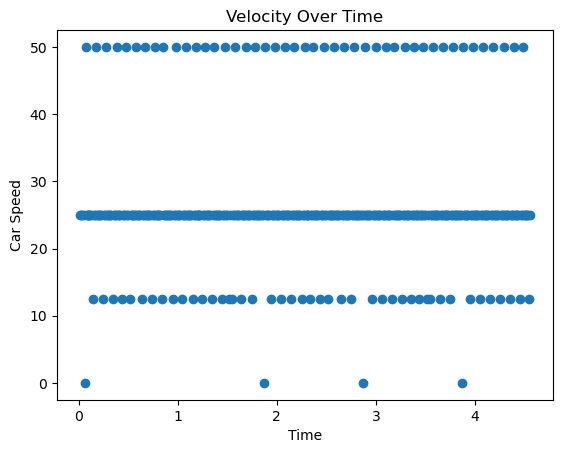

[(0.01, 24.9927), (0.02, 24.9927), (0.03, 24.9927), (0.05, 25.0012), (0.06, 0.0), (0.07, 50.0024), (0.08, 25.0181), (0.09, 25.0096), (0.1, 24.9566), (0.11, 25.0181), (0.12, 24.9736), (0.13, 25.0181), (0.15, 12.5133), (0.16, 24.9736), (0.17, 25.0266), (0.18, 49.9642), (0.19, 25.0351), (0.2, 24.9821), (0.21, 24.9821), (0.22, 24.9906), (0.23, 25.052), (0.25, 12.4953), (0.26, 24.9991), (0.27, 24.9991), (0.28, 49.9981), (0.29, 25.0076), (0.3, 24.9549), (0.31, 25.016), (0.32, 25.0076), (0.33, 25.016), (0.35, 12.4817), (0.36, 25.0245), (0.37, 25.016), (0.38, 24.9719), (0.39, 50.0049), (0.4, 25.033), (0.41, 24.9805), (0.42, 24.9805), (0.44, 12.4945), (0.45, 25.0415), (0.46, 24.989), (0.47, 24.9975), (0.48, 49.995), (0.49, 24.9975), (0.5, 25.006), (0.52, 12.5073), (0.53, 25.006), (0.54, 24.9708), (0.55, 25.023), (0.56, 24.9708), (0.57, 25.0316), (0.58, 49.9844), (0.59, 25.005), (0.6, 25.005), (0.61, 24.9703), (0.62, 25.0221), (0.64, 12.4937), (0.65, 24.996), (0.66, 25.0045), (0.67, 49.9918), (0

C:\Users\irosa\AppData\Local\Temp\ipykernel_4544\167598400.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  speed = dist_between_frames/time


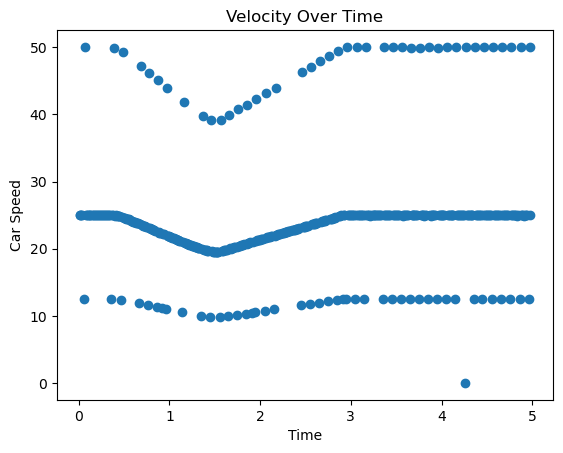

[(0.01, 24.984), (0.02, 25.0302), (0.03, 24.984), (0.04, 24.9752), (0.06, 12.5151), (0.07, 49.9965), (0.08, 24.984), (0.09, 25.0214), (0.1, 24.984), (0.11, 25.0214), (0.12, 24.9752), (0.13, 24.984), (0.15, 25.0027), (0.16, 25.0214), (0.17, 24.984), (0.18, 25.0214), (0.19, 24.9752), (0.2, 25.0302), (0.21, 24.9752), (0.22, 25.0302), (0.24, 24.9982), (0.25, 24.984), (0.26, 25.0214), (0.27, 24.984), (0.28, 25.0214), (0.29, 24.9752), (0.3, 25.0302), (0.31, 24.9752), (0.32, 25.0125), (0.33, 24.9752), (0.34, 25.0214), (0.36, 12.4876), (0.37, 25.0214), (0.38, 24.9574), (0.39, 49.9433), (0.4, 24.9219), (0.41, 24.9505), (0.42, 24.8953), (0.43, 24.8687), (0.44, 24.796), (0.45, 24.8244), (0.47, 12.3945), (0.48, 24.7072), (0.49, 49.3257), (0.5, 24.6097), (0.51, 24.5191), (0.52, 24.4836), (0.53, 24.4768), (0.54, 24.3488), (0.55, 24.3507), (0.57, 24.2468), (0.58, 24.1803), (0.59, 24.0897), (0.6, 24.0454), (0.61, 24.001), (0.62, 23.9656), (0.63, 23.875), (0.64, 23.8306), (0.65, 23.7863), (0.67, 11.852

In [34]:
data_parent_folder = 'raw_data'
filenames = ['AGPilot-10-6-22(1)']

subNum = 0
subject_data_folder = os.path.join( data_parent_folder, filenames[subNum])
this_sub_data = subject_data(subject_data_folder)

BRT_list = []

#Iterate through every trial for analysis for this one subject
for idx, row in this_sub_data.results.iterrows():
    
    # Grab data from a specific trial DONE
    a_trial = this_sub_data.get_trial_from_index(idx)
    trial_start_time = this_sub_data.results['start_time'][idx]

    
    # Calculating BRT for the trial... not done
    time_of_warning = this_sub_data.results['time_of_warning'][idx]
    brt = a_trial.calculate_BRT(time_of_warning)
    BRT_list.append(brt)
    
    # Alternate BRT : Time to contact
    
    # Calculating maximum deceleration of the car's speed for the trial and time at which it happens for the trial
    car_speed = a_trial.calculate_car_speed()
    print(car_speed)

    # Calculating the largest steering wheel angle change and the time at which it happens for the trial
    wheel_angle_over_time = a_trial.get_wheel_angle_data()
    filtered_wheel_data = a_trial.filter_wheel_data(wheel_angle_over_time)
    #time_of_max_steering_wheel_acc = a_trial.max_wheel_velocity(filtered_wheel_data)
    

# Calculating fraction of collisions over the time of the participant's session
if_collision_occurred = this_sub_data.results['collision_has_occurred']
count_no_collisions = 0

for result in if_collision_occurred:
    if result == False:
        count_no_collisions += 1
        
perc_of_no_collisions= count_no_collisions/len(if_collision_occurred)  *100

print("This subject successfully avoided collisions by "+ str(perc_of_no_collisions) + "%")


# Outputting some data
this_sub_data.results['break_reaction_time'] = BRT_list

In [35]:
'''no_NaN_location = []
BRT_amended=[]
ObsVis_amended = []

count2 = -1
for brt in BRT_list:
    count2 +=1
    if brt != "NaN":
        no_NaN_location.append(count2)
        BRT_amended.append(brt)

obstacle_vis = this_sub_data.results['obstacle_visibility']

for loc in no_NaN_location:
    value = obstacle_vis.iloc(loc)
    ObsVis_amended.append(value)
    
print(ObsVis_amended)'''

'no_NaN_location = []\nBRT_amended=[]\nObsVis_amended = []\n\ncount2 = -1\nfor brt in BRT_list:\n    count2 +=1\n    if brt != "NaN":\n        no_NaN_location.append(count2)\n        BRT_amended.append(brt)\n\nobstacle_vis = this_sub_data.results[\'obstacle_visibility\']\n\nfor loc in no_NaN_location:\n    value = obstacle_vis.iloc(loc)\n    ObsVis_amended.append(value)\n    \nprint(ObsVis_amended)'

In [29]:
data_parent_folder = 'raw_data'
filenames = ['AGPilot-10-6-22(1)']

subNum = 0
subject_data_folder = os.path.join( data_parent_folder, filenames[subNum])
this_sub_data = subject_data(subject_data_folder)
a_trial = this_sub_data.get_trial_from_index(21)
time_dif = a_trial.car_data['time'].diff()

car_deltaX = a_trial.car_data['pos_x'].diff()
car_deltaZ = a_trial.car_data['pos_z'].diff()
car_distMoved = np.sqrt( car_deltaX**2 + car_deltaZ**2 ) 
car_speed = car_distMoved[1:] / time_dif[:-1]

#pos_x_interp = np.interp
#a_trial.car_data['pos_x']

<AxesSubplot:>

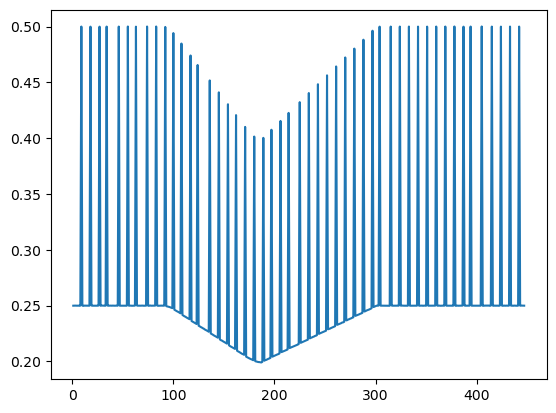

In [38]:
#car_speed = car_distMoved[:-1] / time_dif[1:]
car_distMoved.plot()


<AxesSubplot:>

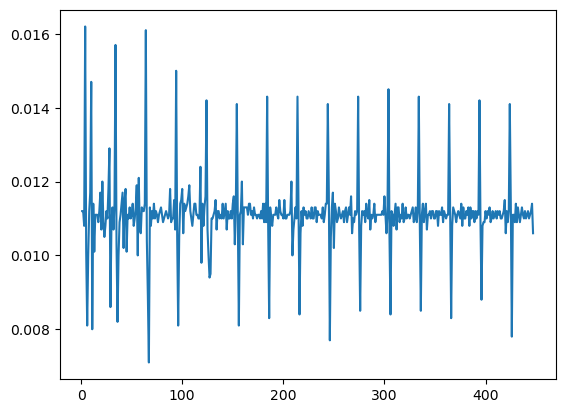

In [37]:
time_dif.plot()